#Лабораторна робота №2. Оцінювання важливості ознак і вибір значущих ознак (feature selection)


**Виконала** студентка групи КІ-41мп Додонова Марія.

##Завдання

1. Опрацювати матеріали уроку U-3.
2. Дослідити ДВА набори даних з багатьма ознаками.

- Перший набір обрати з репозиторію машинного навчання UCI:  https://archive.ics.uci.edu/datasets.
Дані можуть відповідати задачі класифікації чи регресії.  Обрати набір з кількістю ознак більше 10. Початковими даними може бути зображення. Тоді задача - оцінити важливість кожного пікселя зображення.

- Другий набір даних згенерувати, використовуючи make_classification або make_regression.
В процесі генерування задати параметри:
 - n_samples > 100,
 - n_features > 15,
 - n_informative > 2 - кількість інформативних ознак,
 - n_redundant > 2 - кількість надлишкових ознак (для make_classification).

Додатково проаналізувати результати роботи алгоритмів на наборі, де n_features  > n_samples.

3. Оцінити важливість ознак, використовуючи наступні алгоритми, реалізовані в scikit-learn python:
- Univariate feature selection,
- Recursive feature elimination (RFE) та його модифікацію з крос-валідацією (RFECV),
- Sequential Feature Selection,
- SelectFromModel.

Розглянути два варіанти алгоритму Sequential Feature Selection: forward і backward.

Алгоритм SelectFromModel дослідити для наступних двох моделей класифікації/регресії:
- які підтримують L1-регуляризацію (наприклад, логістична регресія або LinearSVC для задачі класифікації та lasso або LinearSVR для задачі регресії),
- випадкових лісів.

4. Оцінити важливість ознак, використовуючи алгоритми, реалізовані в mlxtend python:
- ColumnSelector,
- SequentialFeatureSelector.
5. Порівняти результати за різними алгоритмами.
6. Для штучно згенерованих даних порівняти результати з умовами моделювання.
7. Зробити висновки.

##Виконання роботи

###Дослідження наборів даних з багатьма ознаками

Першим набором даних оберемо Breast Cancer Wisconsin (Diagnostic) з репозиторію машинного навчання UCI: https://archive.ics.uci.edu/datasets. Дані цього набору відповідають задачі класифікації. Набір містить 30 ознак.

In [ ]:
import pandas as pd
import numpy as np

df_bcw = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/"
    "breast-cancer-wisconsin/wdbc.data",
    header=None
)

features_bcw = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se",
    "fractal_dimension_se", "radius_worst", "texture_worst",
    "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst",
    "symmetry_worst", "fractal_dimension_worst"
]
df_bcw.columns = ["id", "diagnosis"] + features_bcw

features_bcw = np.array(features_bcw)
bcw_labels_mapping = {"B": 0, "M": 1}
df_bcw["diagnosis"] = df_bcw["diagnosis"].map(bcw_labels_mapping)
df_bcw.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


 Приведемо ознаки до єдиного масштабу за допомогою стандартизації.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_bcw, y_bcw = df_bcw.iloc[:, 2:].values, df_bcw.iloc[:, 1].values

stdsc = StandardScaler()
X_bcw = stdsc.fit_transform(X_bcw)
X_bcw

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

Другий набір даних згенеруємо, використовуючи make_classification. В процесі генерування задамо параметри:
* n_samples = 600,
* n_features = 20,
* n_informative = 5 - кількість інформативних ознак,
* n_redundant = 5 - кількість надлишкових ознак.

In [ ]:
from sklearn.datasets import make_classification

# s - synthetic
X_s, y_s = make_classification(
    n_samples=600, n_features=20, n_informative=5, n_redundant=5,
    n_repeated=0, n_classes=5, n_clusters_per_class=1, class_sep=0.8,
    random_state=0
)
features_s = [f"F{n}" for n in range(X_s.shape[1])]
features_s = np.array(features_s)
X_s

array([[ 0.26755103,  0.19832706, -0.64679202, ..., -0.38864297,
         2.11413797, -0.17908241],
       [-0.34823128, -1.37121649, -0.78312954, ..., -1.75755175,
         1.18152997,  0.97362584],
       [-0.18008084,  1.28298121,  1.84741402, ..., -1.30817112,
         0.88245828, -0.22989994],
       ...,
       [ 0.37910337, -1.37530195,  0.24498521, ..., -1.01258593,
         1.85226727,  2.41234774],
       [-0.369858  ,  0.12757382,  1.31523921, ..., -0.16077399,
         0.52447244, -0.76622817],
       [-1.12801174, -2.12138944, -0.35112153, ...,  0.28959789,
         4.43970819, -1.34878132]])

Додатково проаналізуємо результати роботи алгоритмів на наборі, де n_features > n_samples.

In [ ]:
# shd - synthetic high dimension
X_shd, y_shd = make_classification(
    n_samples=100, n_features=120, n_informative=10, n_redundant=5,
    n_repeated=0, n_classes=5, n_clusters_per_class=1, class_sep=0.8,
    random_state=0
)
features_shd = [f"F{n}" for n in range(X_shd.shape[1])]
features_shd = np.array(features_shd)
X_shd

array([[ 0.3083239 , -1.88380246, -0.09849633, ...,  0.49749717,
         0.09566652,  0.25993976],
       [ 0.06948254,  0.59220736,  0.95329301, ..., -0.85797866,
         0.5488113 ,  1.53765565],
       [-0.91316535,  0.79785343,  0.85771967, ..., -0.50746604,
        -0.06873389, -0.81848067],
       ...,
       [ 0.93462629,  1.07440627, -1.55131831, ...,  2.11527004,
        -0.6623418 ,  0.45553177],
       [-1.80448225, -1.40380789, -0.96868803, ...,  0.10724458,
         0.20888413,  1.31184388],
       [ 0.9736913 , -0.8425412 , -0.89453495, ..., -3.08229793,
        -1.32653352,  1.22101446]])

In [ ]:
datasets = {
    "bcw": (X_bcw, y_bcw, features_bcw),
    "s": (X_s, y_s, features_s),
    "shd": (X_shd, y_shd, features_shd)
}

Напишемо код для побудови графіків та виводу результатів досліджень.

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(
    features, scores, title="Feature Importance",
    xlabel="Importance Score", ylabel="Features"
):
  indices = np.argsort(scores)[::-1]
  sorted_features = np.array(features)[indices]
  sorted_scores = np.array(scores)[indices]

  plt.figure(figsize=(16, 16))
  plt.barh(sorted_features, sorted_scores)
  plt.xlabel(xlabel=xlabel)
  plt.ylabel(ylabel=ylabel)
  plt.title(title)
  plt.gca().invert_yaxis()
  plt.grid(axis="x", linestyle="--", alpha=0.7)

  plt.show()

def plot_feature_selection_performance(
    feature_counts, scores, std_scores=None,
    title="Feature Selection Performance", xlabel="Features Number",
    ylabel="Model Accuracy"
):
    plt.figure(figsize=(16, 10))

    if std_scores is not None:
        plt.errorbar(
            feature_counts, scores, yerr=std_scores, fmt="-o", capsize=5
        )
    else:
        plt.plot(feature_counts, scores, marker="o")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    plt.show()

In [ ]:
def output_result(
    dataset, n_features, best_features, selected=None
):
  if dataset == "bcw":
    dataset = "Breast Cancer Wisconsin (Diagnostic) Dataset"
  elif dataset == "s":
    dataset = "synthetc data (n_features < n_samples)"
  elif dataset == "shd":
    dataset = "synthetc data (n_features > n_samples)"
  print(
    f"Best {n_features} features from {dataset}:\n ",
    ", ".join(best_features)
  )

  if selected is not None:
    print("Selected data:")
    print(selected)

  print()

###Оцінювання важливості ознак з використанням алгоритмів, реалізованих в scikit-learn python

Застосуємо алгоритм Univariate feature selection. Реалізуємо його за допомогою SelectKBest із критерієм f_classif. Вибиратимемо n_features кращих ознак залежно від датасету.

Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  radius_mean, perimeter_mean, area_mean, concavity_mean, concave_points_mean, radius_worst, perimeter_worst, area_worst, concave_points_worst



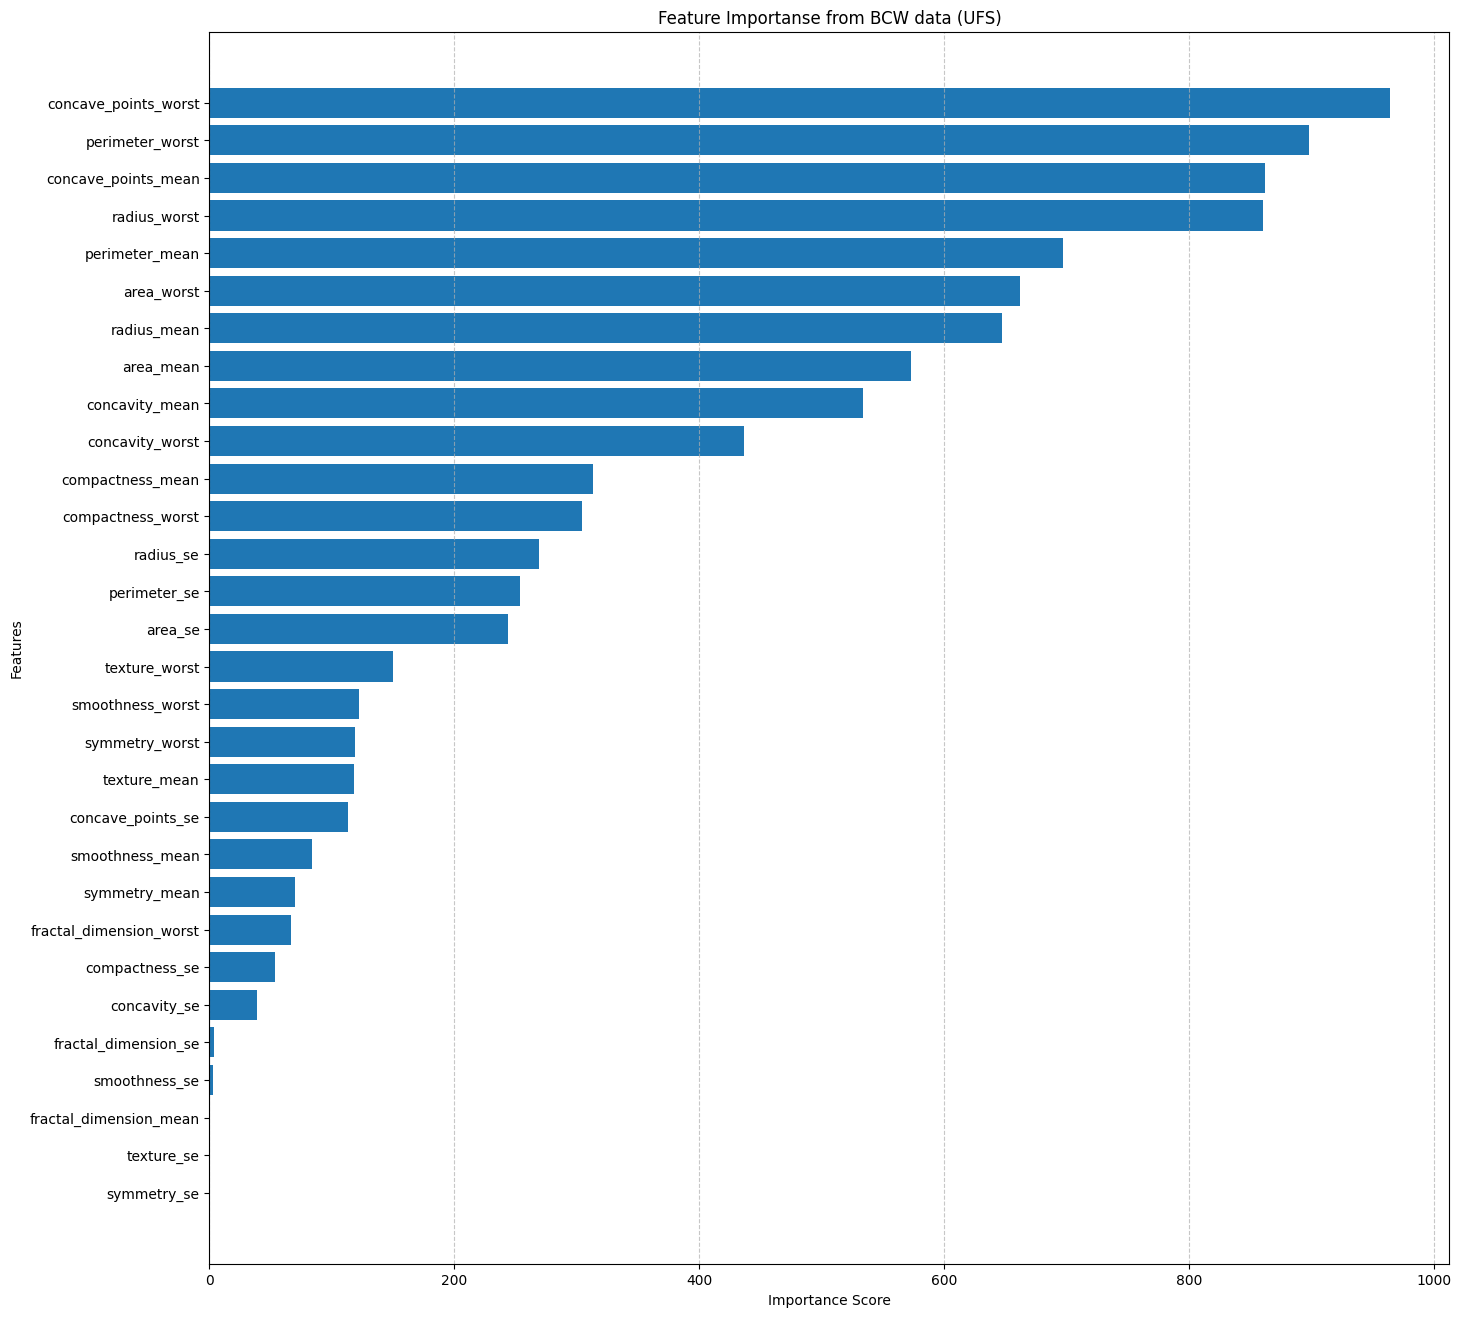

Best 5 features from synthetc data (n_features < n_samples):
  F0, F5, F13, F16, F18



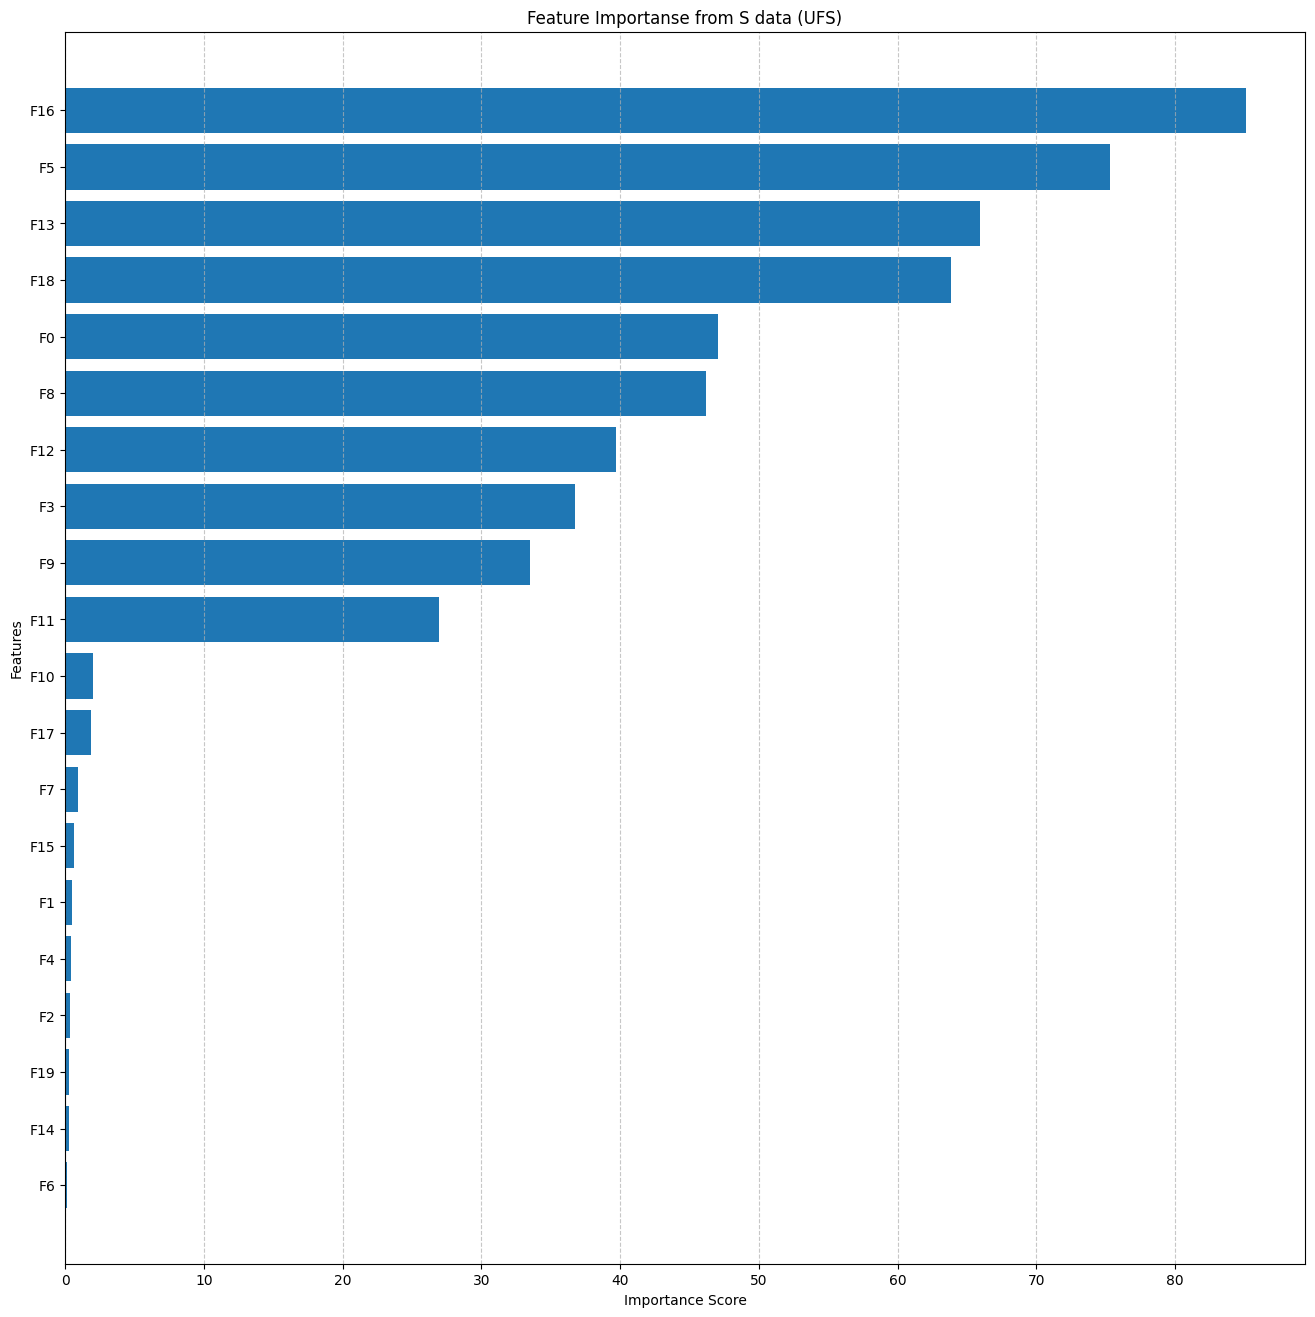

Best 10 features from synthetc data (n_features > n_samples):
  F9, F19, F33, F50, F68, F74, F79, F100, F106, F108



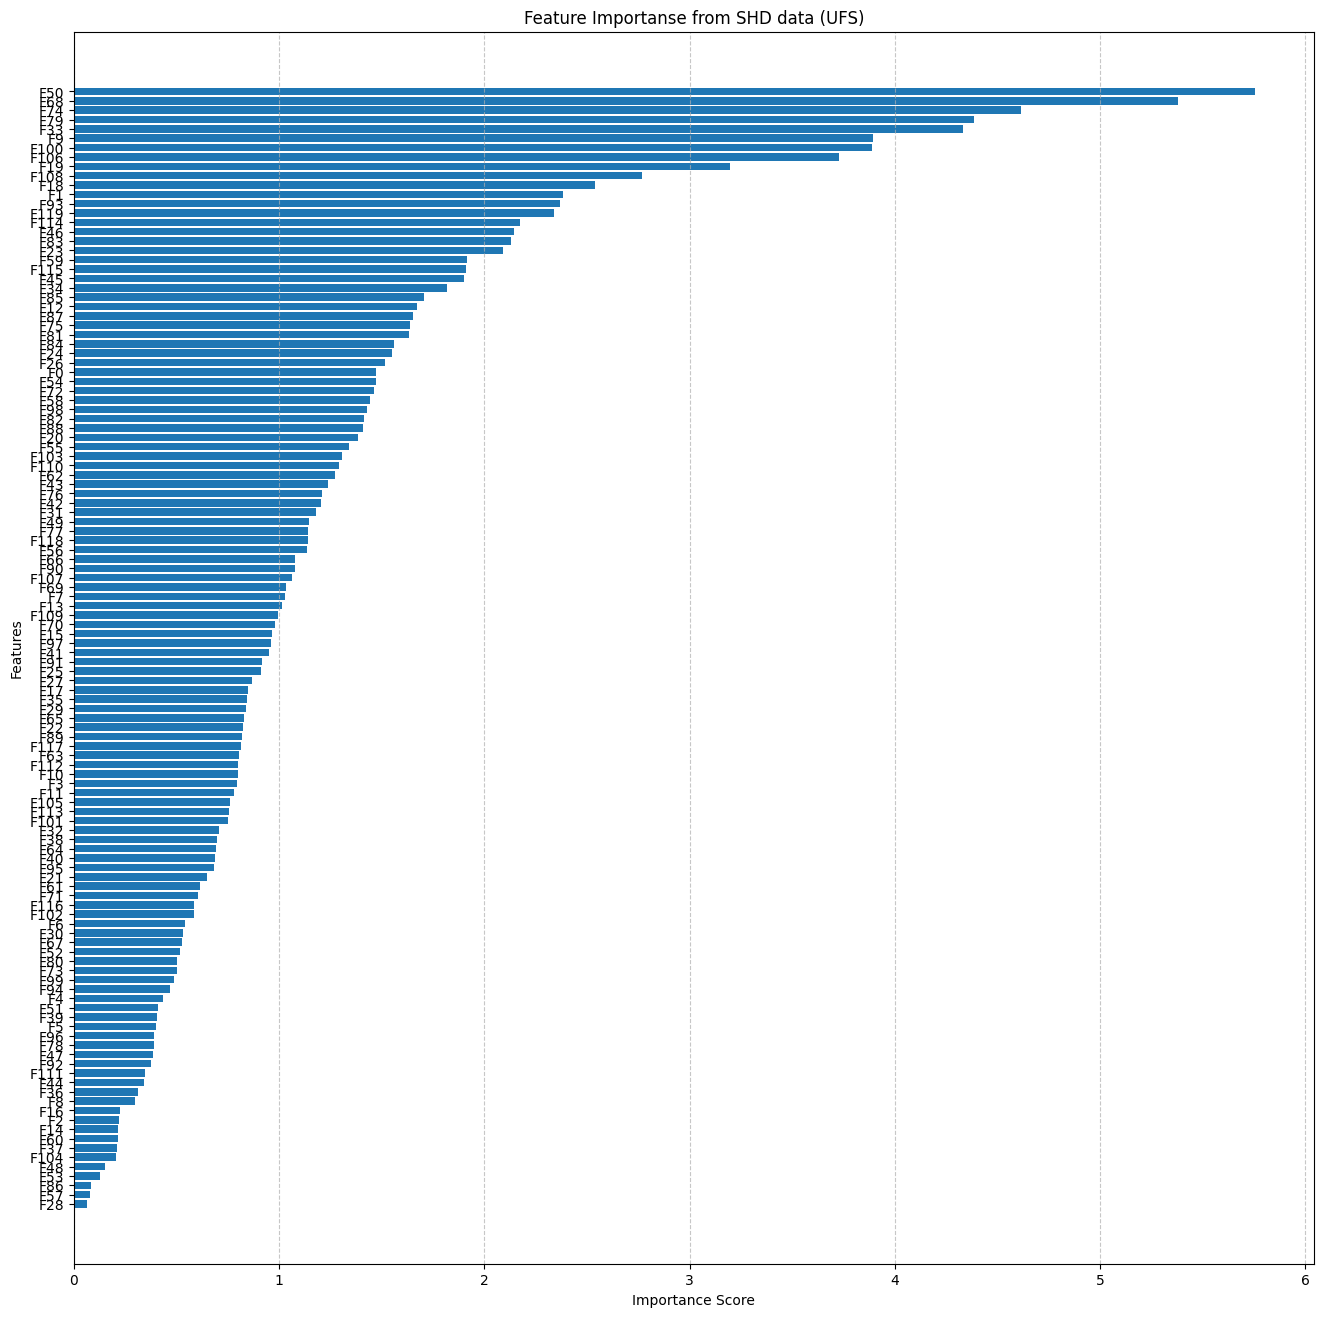

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

def use_UFS(dataset_name, data, n_features):
  X, y, features = data
  ufs = SelectKBest(score_func=f_classif, k=n_features)
  ufs.fit(X, y)
  best_features = ufs.get_feature_names_out(input_features=features)
  output_result(dataset_name, n_features, best_features)
  plot_feature_importance(
      features, ufs.scores_,
      title=f"Feature Importanse from {dataset_name.upper()} data (UFS)"
  )

for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_UFS(dataset, datasets[dataset], n_features)

Застосуємо алгоритм Recursive feature elimination (RFE). Для оцінювання важливості ознак використаємо лінійний SVM. На кожній ітерації видаляється одна найменш значуща ознака.

Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  compactness_mean, concavity_mean, concave_points_mean, area_se, fractal_dimension_se, radius_worst, texture_worst, area_worst, fractal_dimension_worst



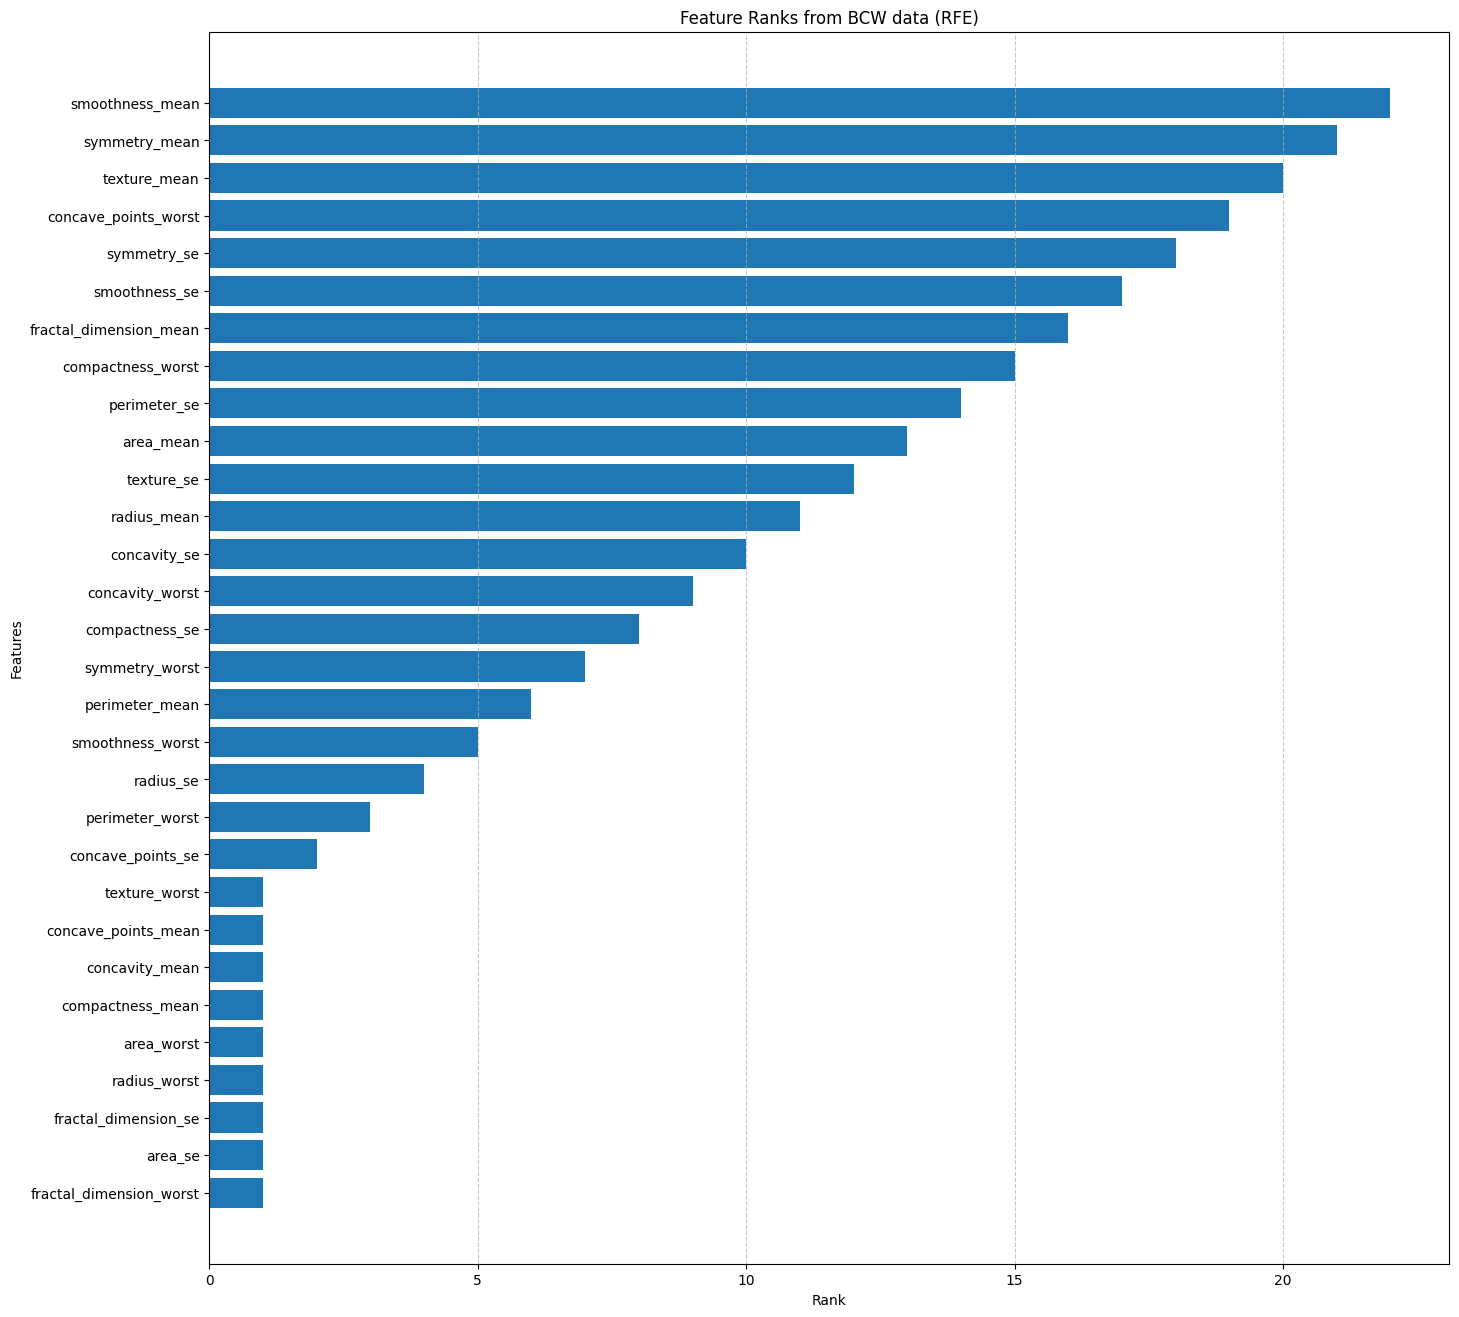

Best 5 features from synthetc data (n_features < n_samples):
  F5, F8, F13, F16, F18



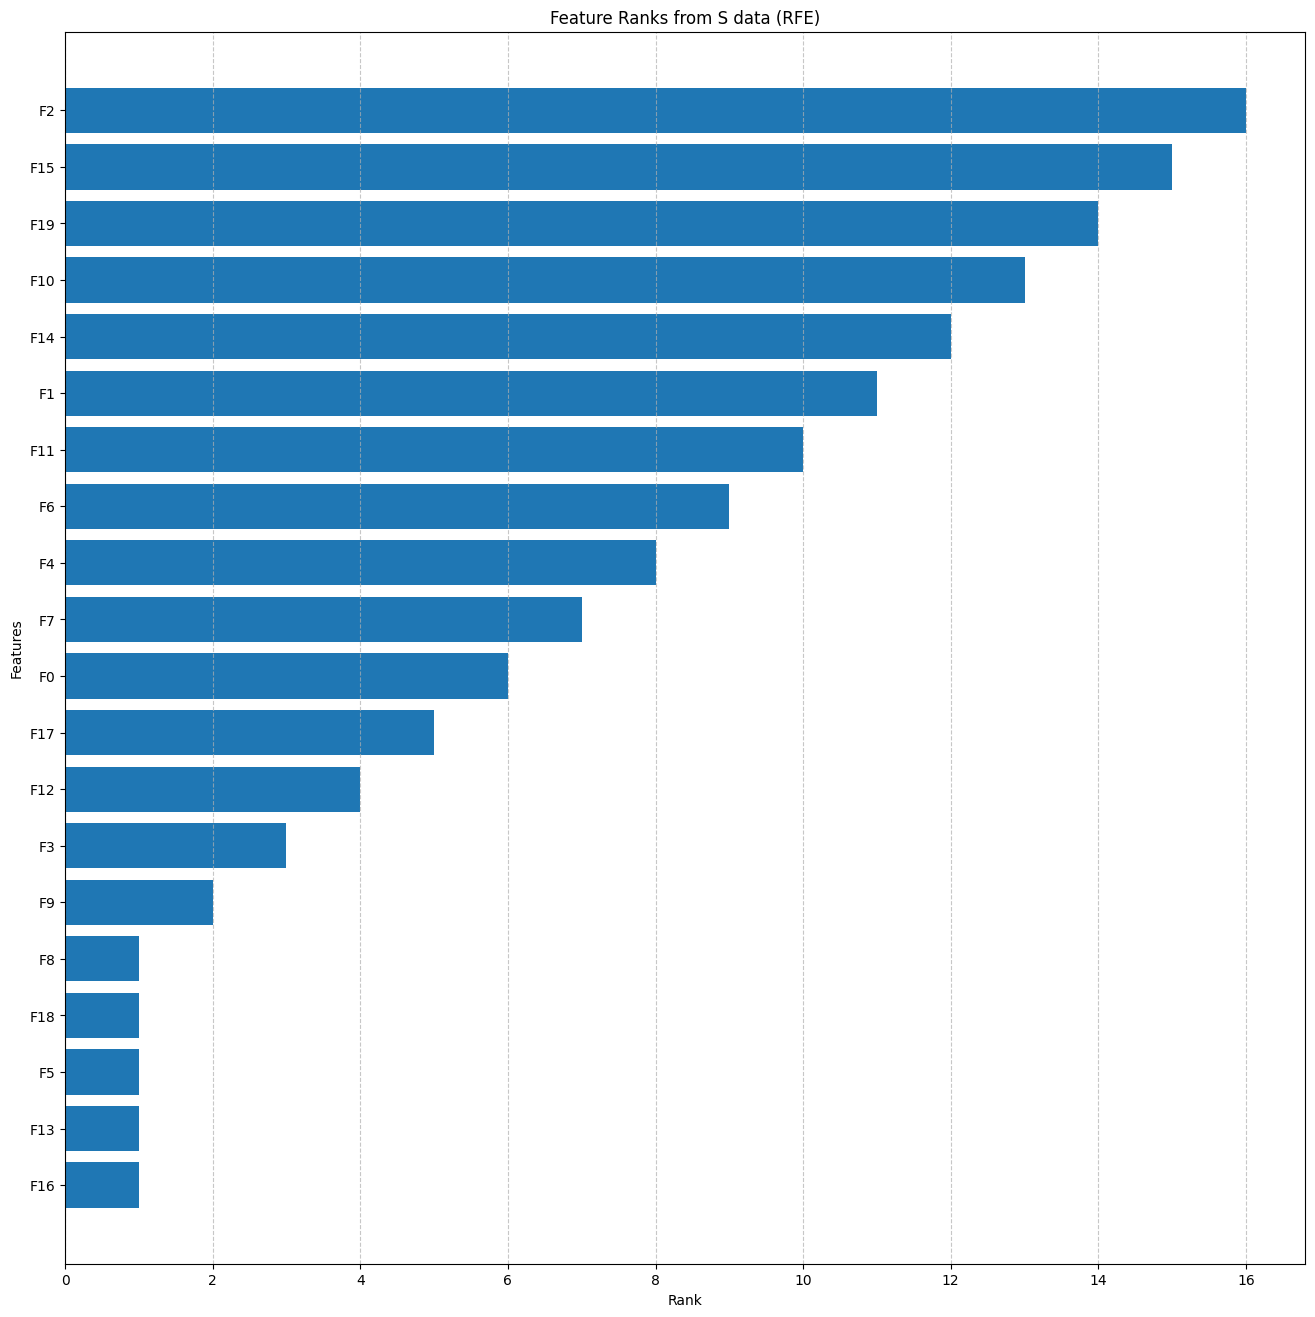

Best 10 features from synthetc data (n_features > n_samples):
  F19, F34, F38, F50, F74, F79, F81, F103, F106, F115



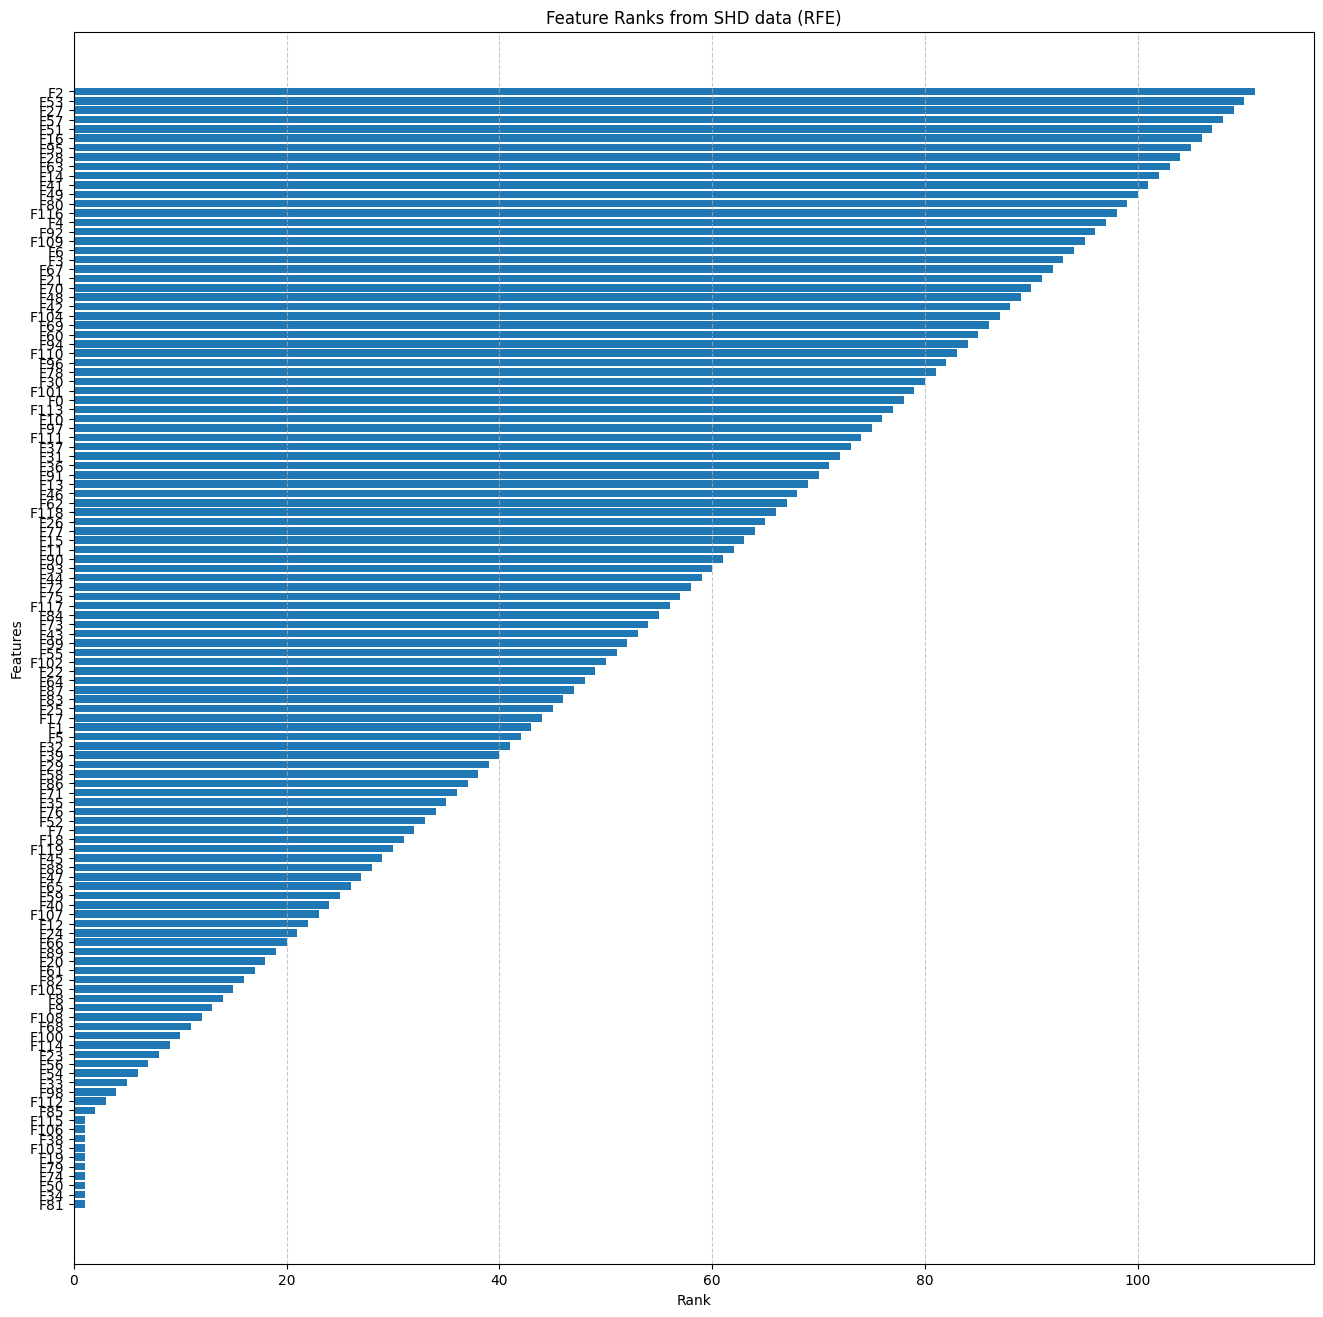

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

def use_RFE(dataset_name, data, n_features):
  X, y, features = data
  svc = SVC(kernel="linear", C=1)
  rfe = RFE(svc, n_features_to_select=n_features, step=1)
  rfe.fit(X, y)
  best_features = rfe.get_feature_names_out(input_features=features)
  output_result(dataset_name, n_features, best_features)
  plot_feature_importance(
      features, rfe.ranking_,
      title=f"Feature Ranks from {dataset_name.upper()} data (RFE)",
      xlabel="Rank"
  )

for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_RFE(dataset, datasets[dataset], n_features)

Застосуємо модифікацію алгоритму Recursive feature elimination з крос-валідацією (RFECV). Для оцінки важливості ознак використаємо логістичну регресію. У якості крос-валідації застосуємо StratifiedKFold(5). Метрикою оберемо точність.

Best 30 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave_points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave_points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave_points_worst, symmetry_worst, fractal_dimension_worst



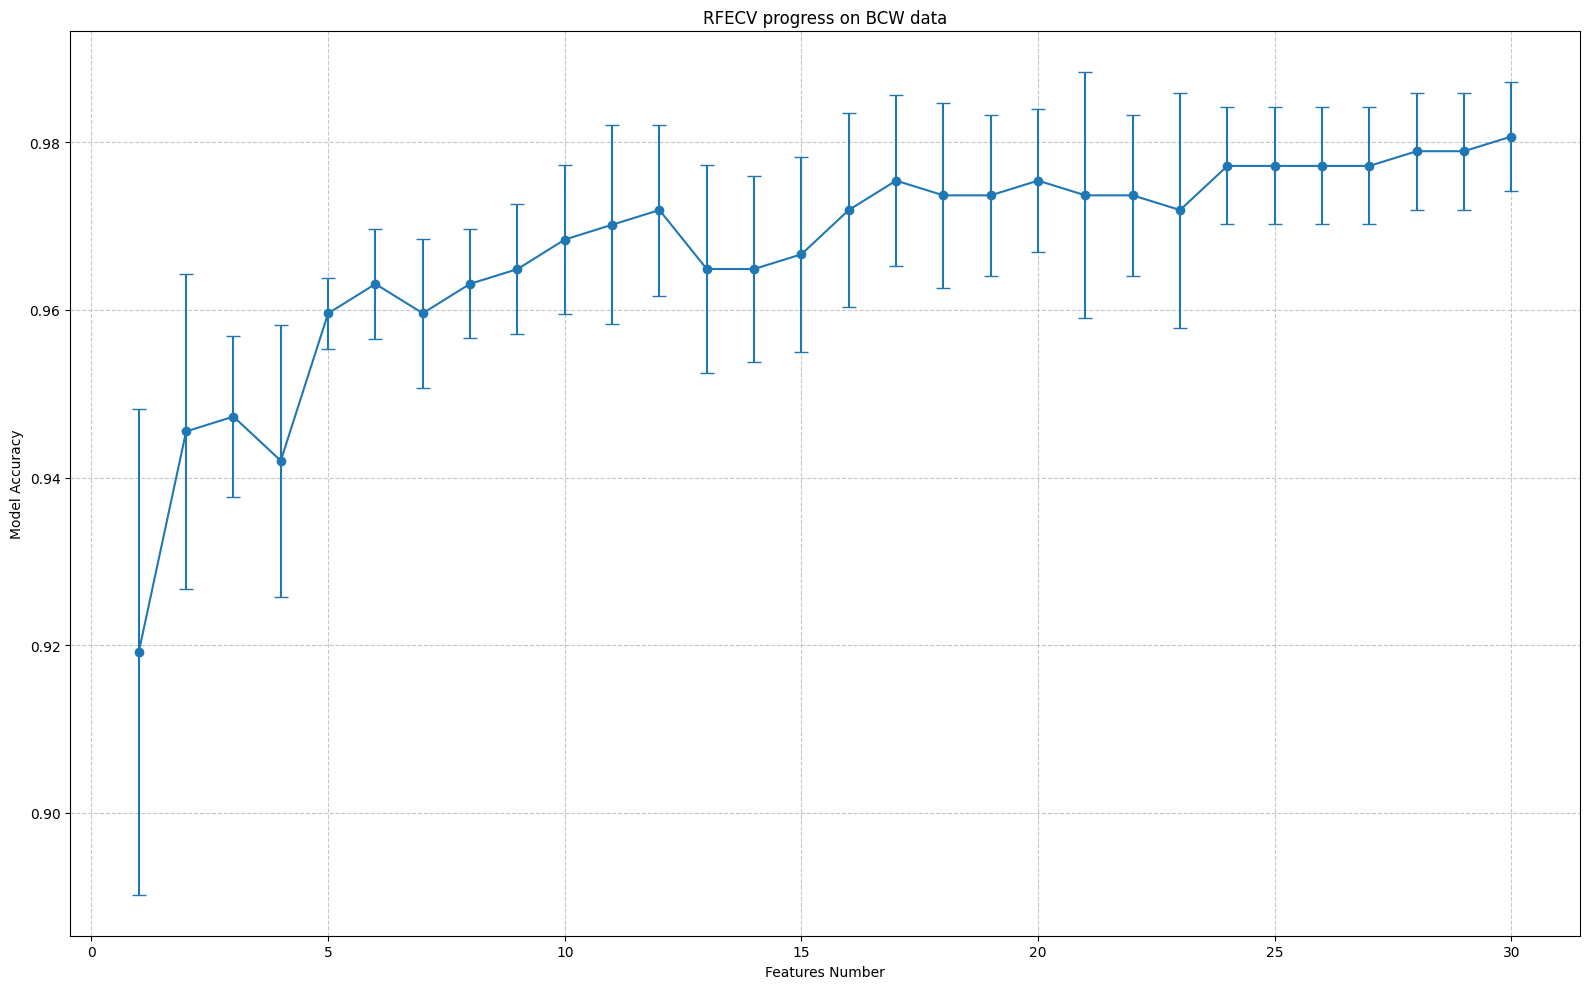

Best 6 features from synthetc data (n_features < n_samples):
  F5, F8, F9, F13, F16, F18



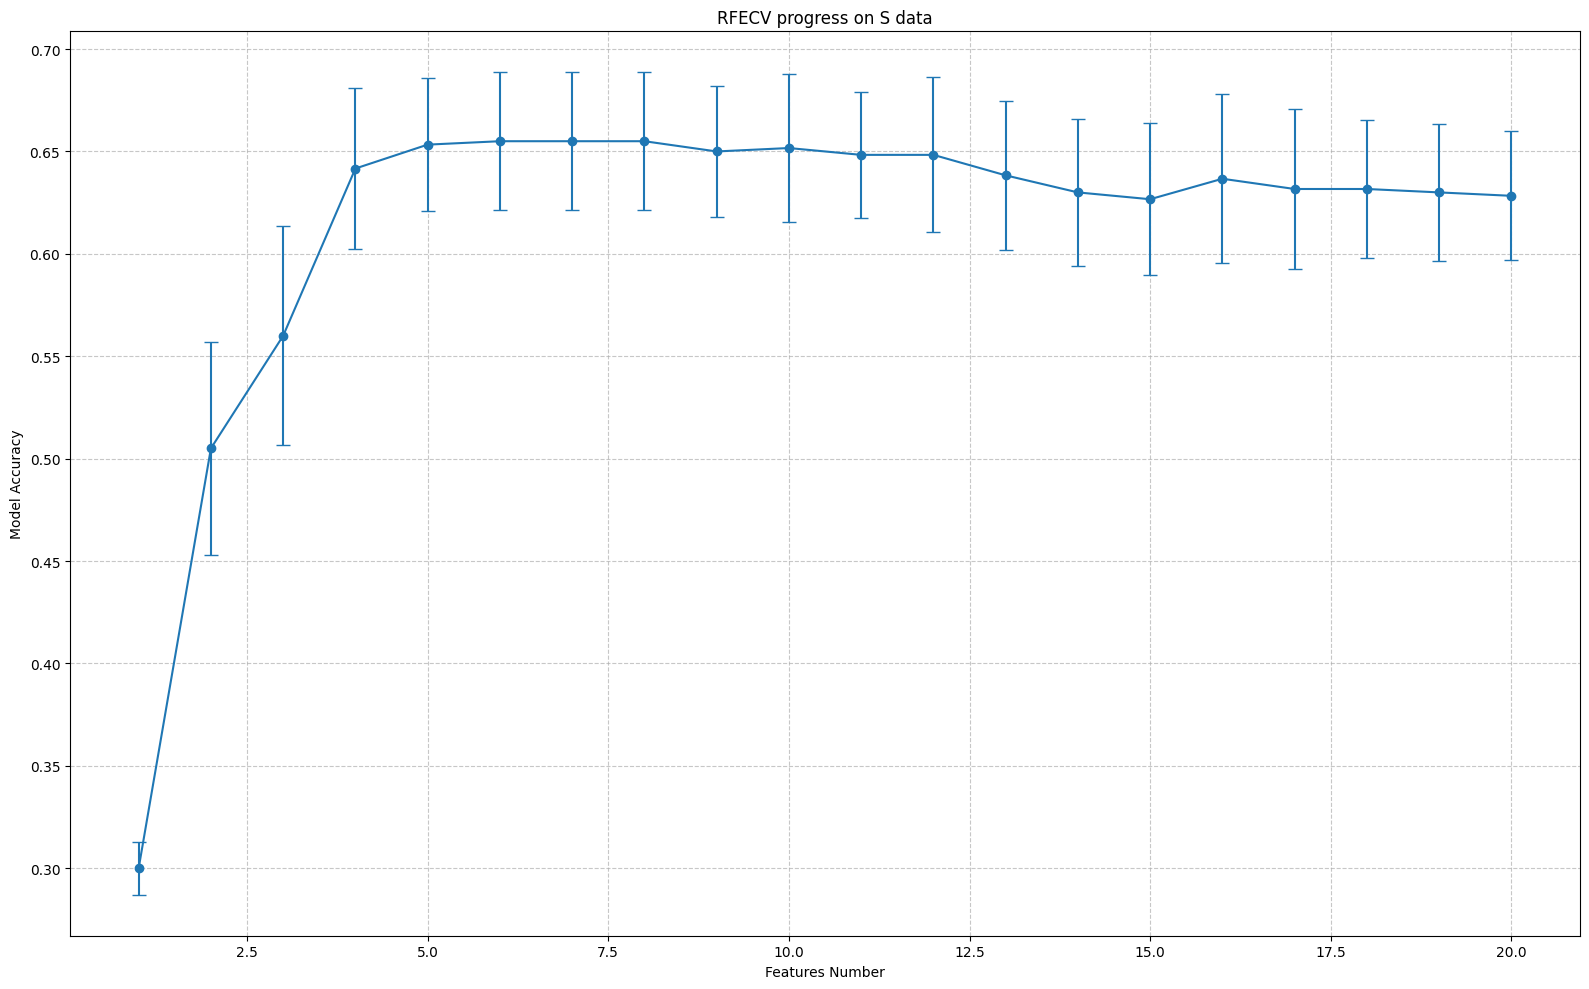

Best 45 features from synthetc data (n_features > n_samples):
  F0, F1, F5, F8, F9, F12, F18, F19, F20, F23, F24, F31, F33, F34, F36, F39, F45, F47, F50, F54, F55, F56, F59, F66, F68, F69, F71, F74, F75, F76, F79, F81, F82, F85, F94, F98, F100, F103, F106, F107, F108, F112, F114, F115, F119



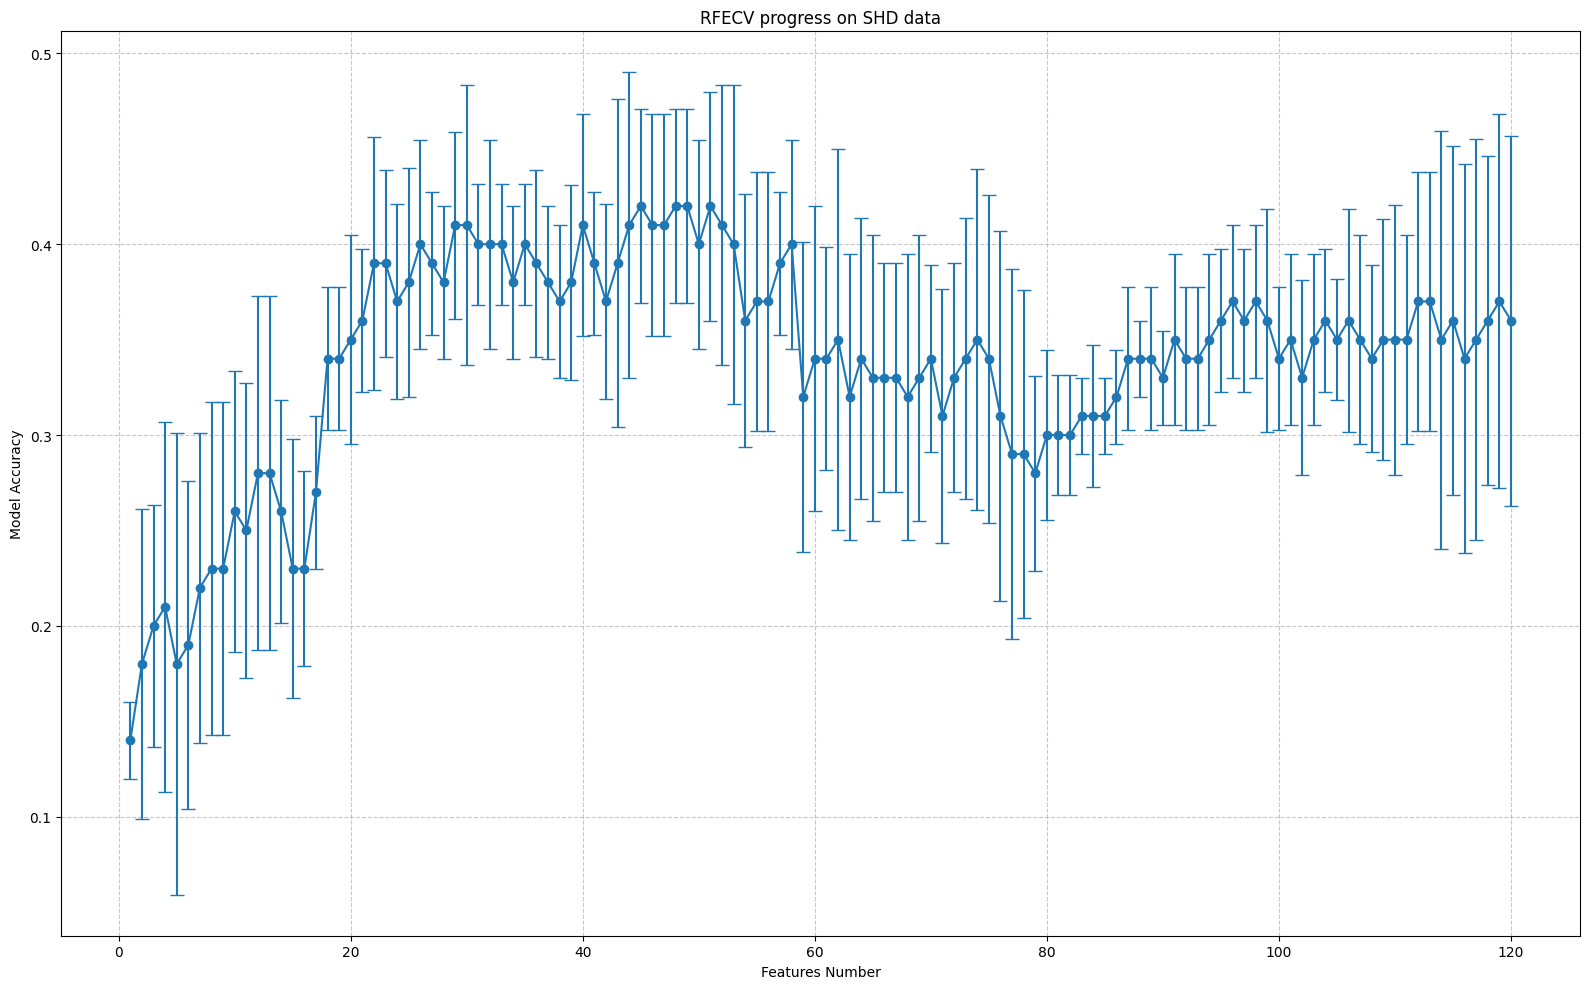

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def use_RFECV(dataset_name, data):
  X, y, features = data
  clf = LogisticRegression()
  cv = StratifiedKFold(5)
  rfecv = RFECV(estimator=clf, step=1, cv=cv, scoring="accuracy")
  rfecv.fit(X, y)
  best_features = rfecv.get_feature_names_out(input_features=features)
  k = rfecv.n_features_
  output_result(dataset_name, k, best_features)
  plot_feature_selection_performance(
      range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
      rfecv.cv_results_["mean_test_score"],
      std_scores=rfecv.cv_results_["std_test_score"],
      title=f"RFECV progress on {dataset_name.upper()} data"
  )

for dataset in datasets:
  use_RFECV(dataset, datasets[dataset])

Застосуємо алгоритм Sequential Feature Selection. Розглянемо варіанти forward та backward цього алгоритму. Спершу реалізуємо обидва варіанти алгоритму. Для оцінки важливості ознак застосовуватимемо алгоритм KNeighborsClassifier, метрикою оцінки буде точність.

In [ ]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SequentialFeatureSelection():
  def __init__(
      self, estimator, k_features, scoring=accuracy_score,
      test_size=0.25, forward=True, random_state=1
  ):
    self.estimator = clone(estimator)
    self.scoring = scoring
    self.k_features = k_features
    self.test_size = test_size
    self.forward = forward
    self.random_state = random_state

  def fit(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=self.test_size, random_state=self.random_state
    )

    self.indices_, self.subsets_, self.scores_ = self._init_fit(
        X_train, y_train, X_test, y_test
    )
    all_features = set(range(X_train.shape[1]))

    while len(self.indices_) != self.k_features:
      scores = []
      subsets = []

      for c in self._calc_combinations(self.indices_, all_features):
        score = self._calc_score(X_train, y_train, X_test, y_test, c)
        scores.append(score)
        subsets.append(c)

      best = np.argmax(scores)
      self.indices_ = tuple(sorted(subsets[best]))
      self.subsets_.append(self.indices_)

      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
    return X[:, self.indices_]

  def _init_fit(self, X_train, y_train, X_test, y_test):
      if self.forward:
        indices, subsets, scores = [], [], []
      else:
        indices = tuple(range(X_train.shape[1]))
        subsets = [indices]
        score = self._calc_score(
            X_train, y_train, X_test, y_test, indices
        )
        scores = [score]

      return indices, subsets, scores

  def _calc_combinations(self, indices, all_features):
    if self.forward:
      remaining = list(all_features - set(indices))
      combs = [tuple(list(indices) + [r]) for r in remaining]
    else:
      combs = combinations(indices, r=len(indices) - 1)

    return combs

  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:, indices])
    score = self.scoring(y_test, y_pred)
    return score

[Forward SFS]
Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  compactness_mean, concave_points_mean, symmetry_mean, texture_se, perimeter_se, area_se, concave_points_se, radius_worst, texture_worst



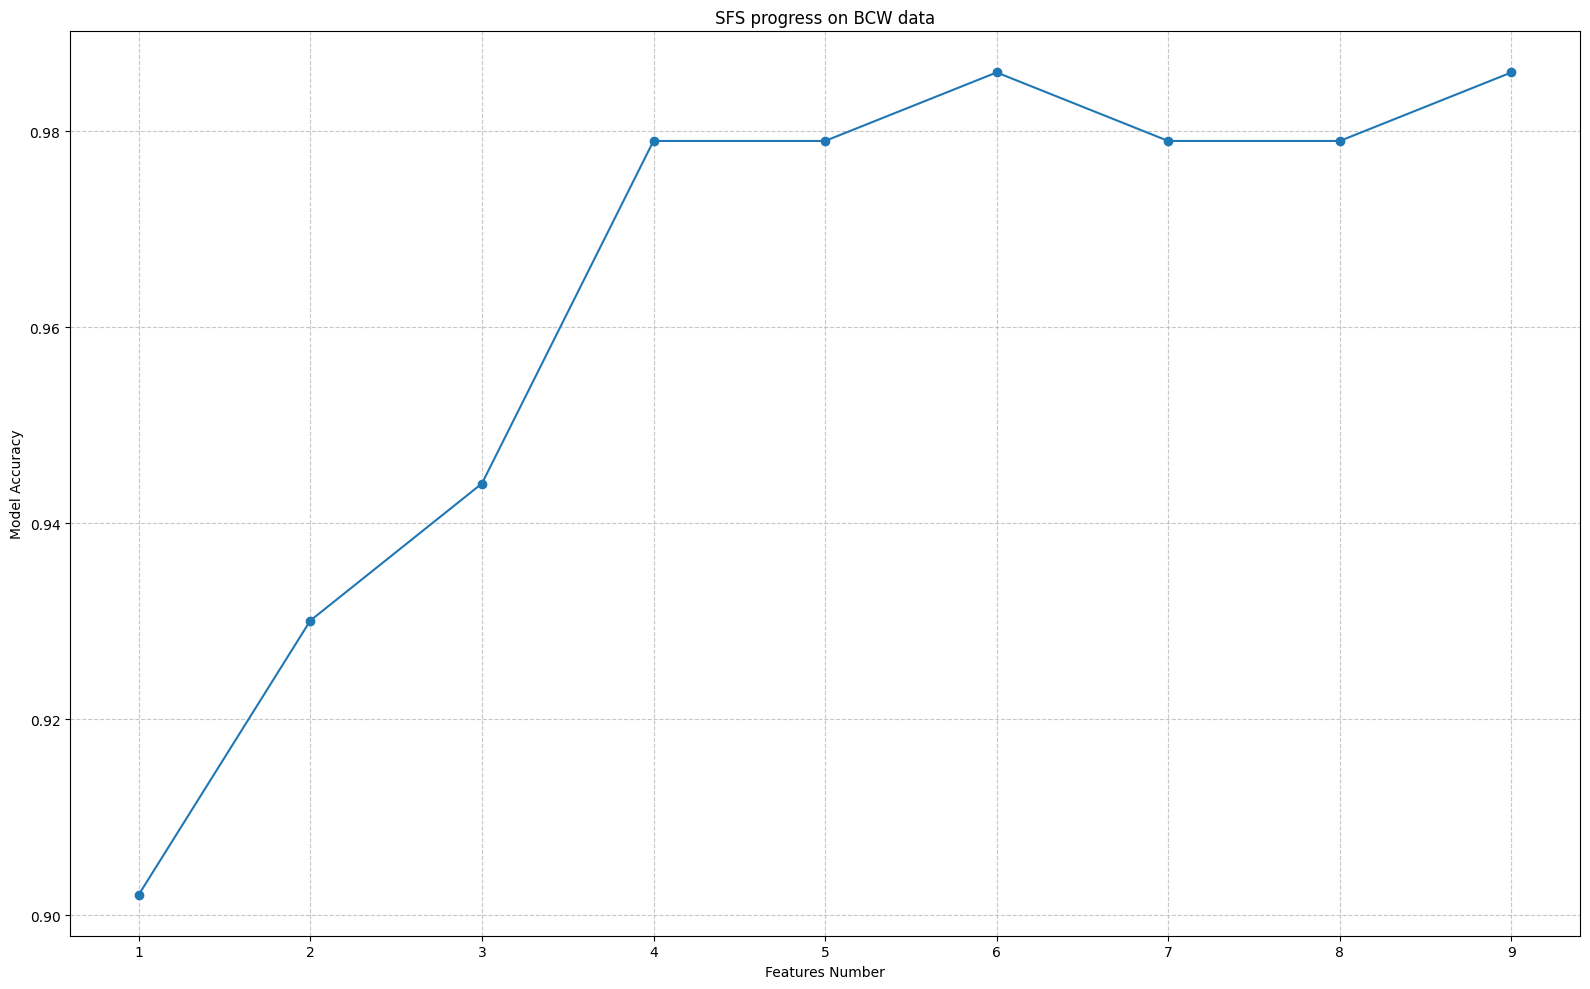

Best 5 features from synthetc data (n_features < n_samples):
  F5, F8, F9, F13, F16



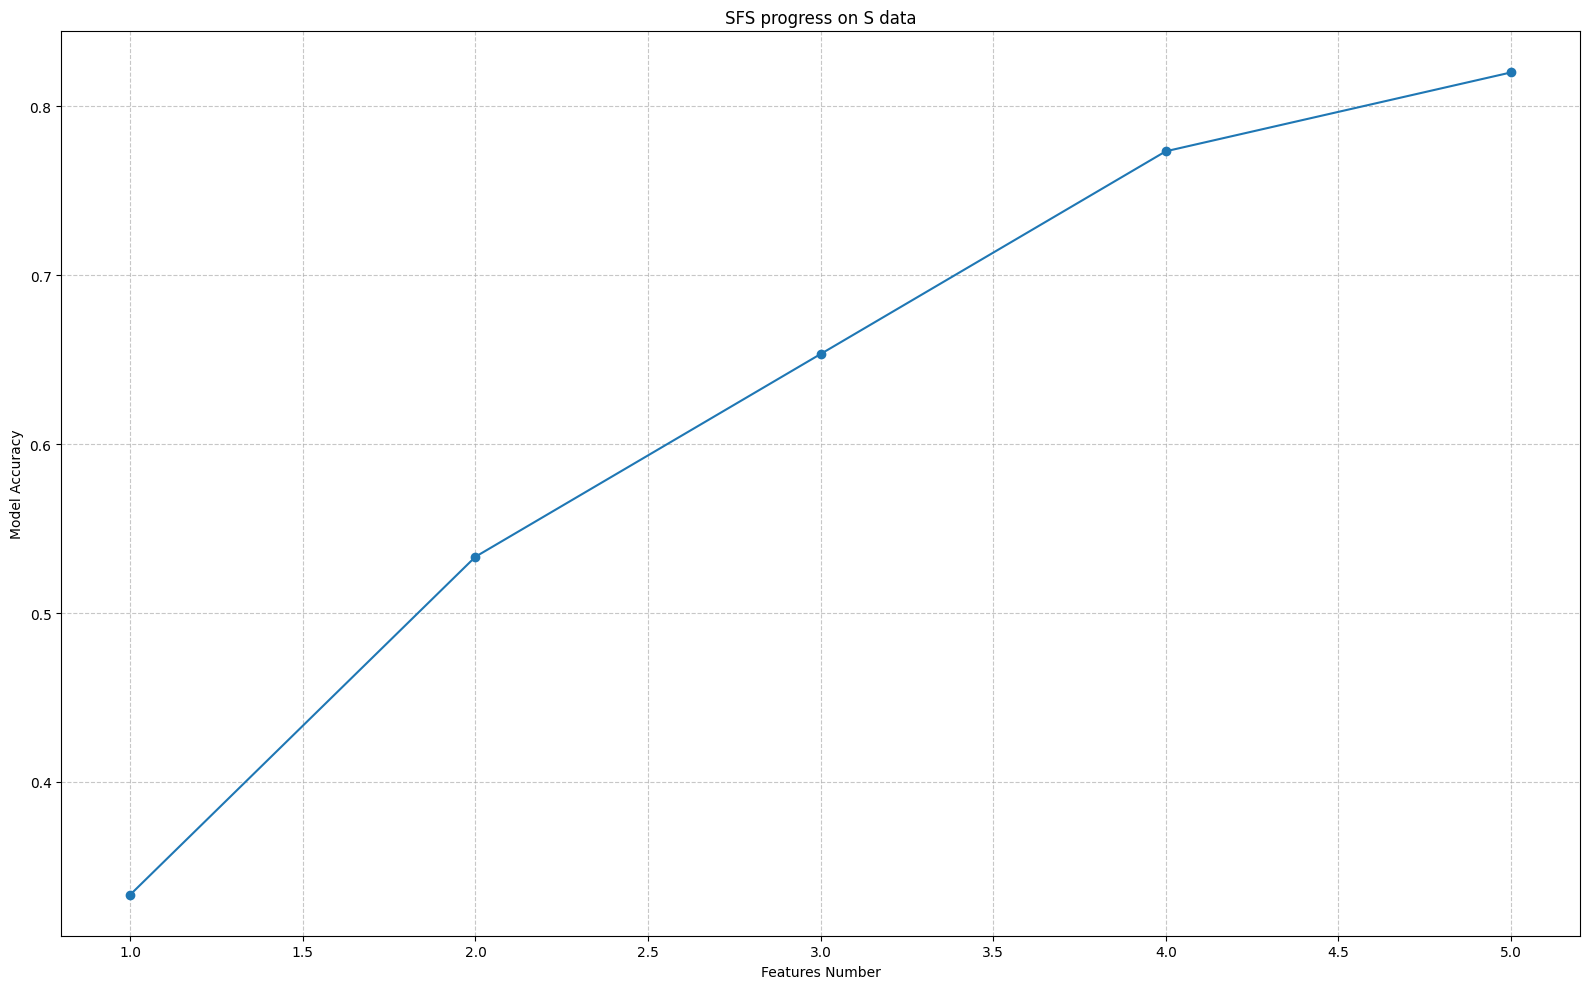

Best 10 features from synthetc data (n_features > n_samples):
  F6, F11, F13, F44, F46, F50, F60, F65, F89, F96



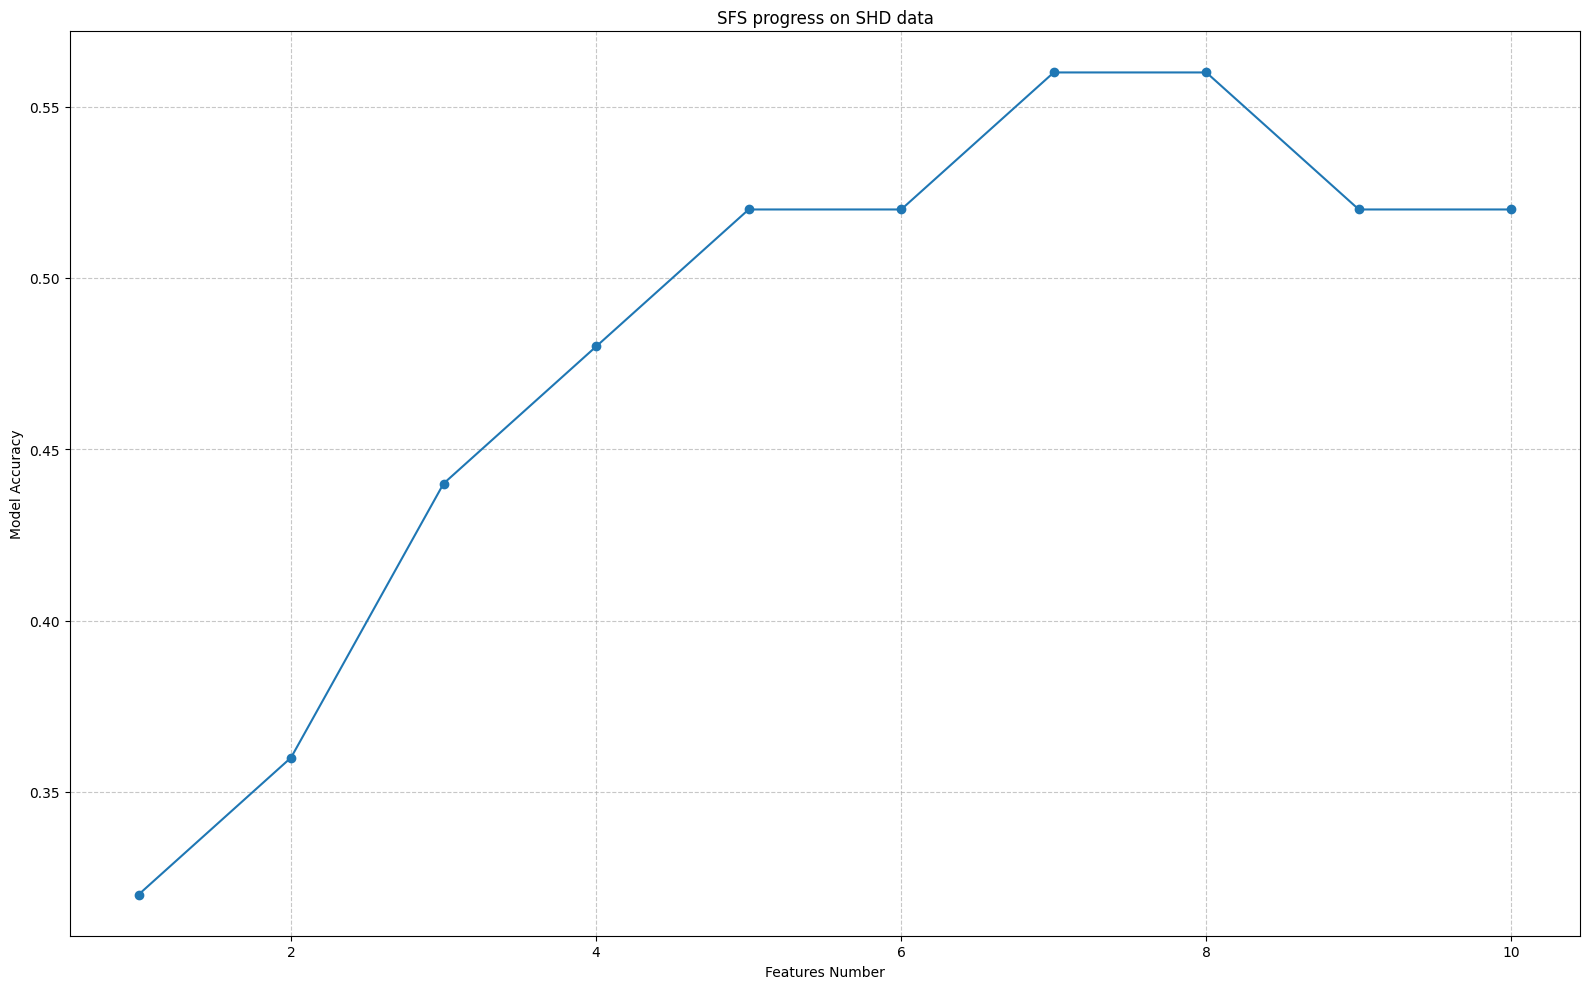


[Backward SFS]
Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  radius_mean, perimeter_mean, smoothness_mean, concave_points_mean, symmetry_mean, texture_se, perimeter_se, smoothness_se, texture_worst



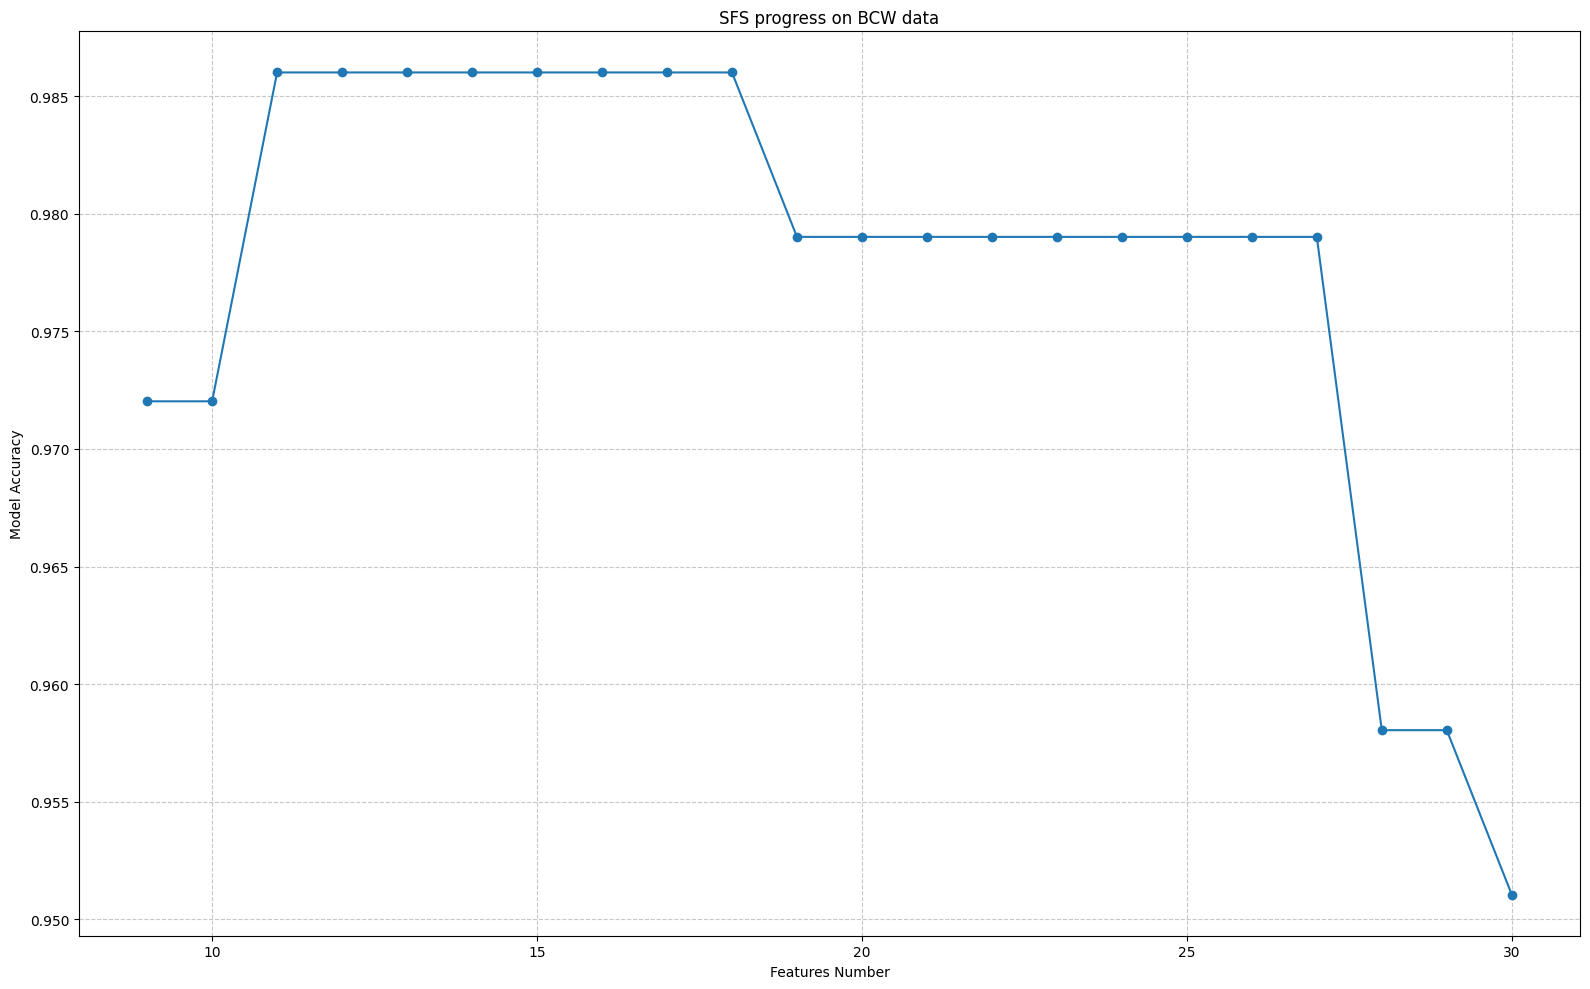

Best 5 features from synthetc data (n_features < n_samples):
  F0, F3, F5, F8, F9



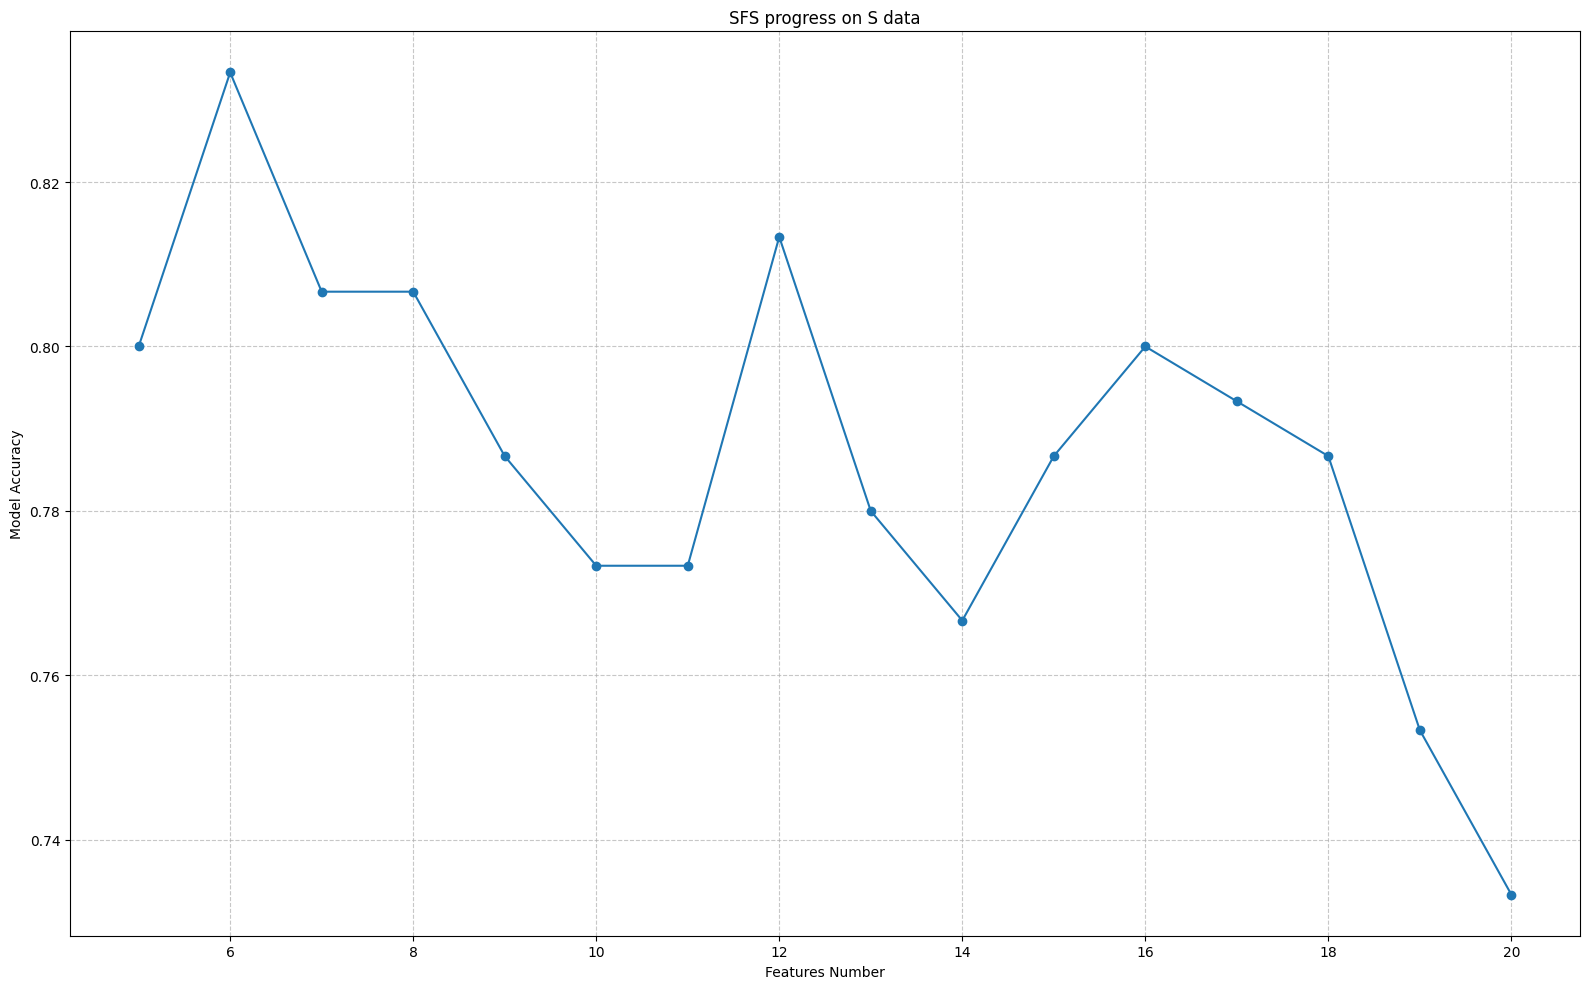

Best 10 features from synthetc data (n_features > n_samples):
  F8, F9, F13, F15, F18, F33, F50, F73, F79, F117



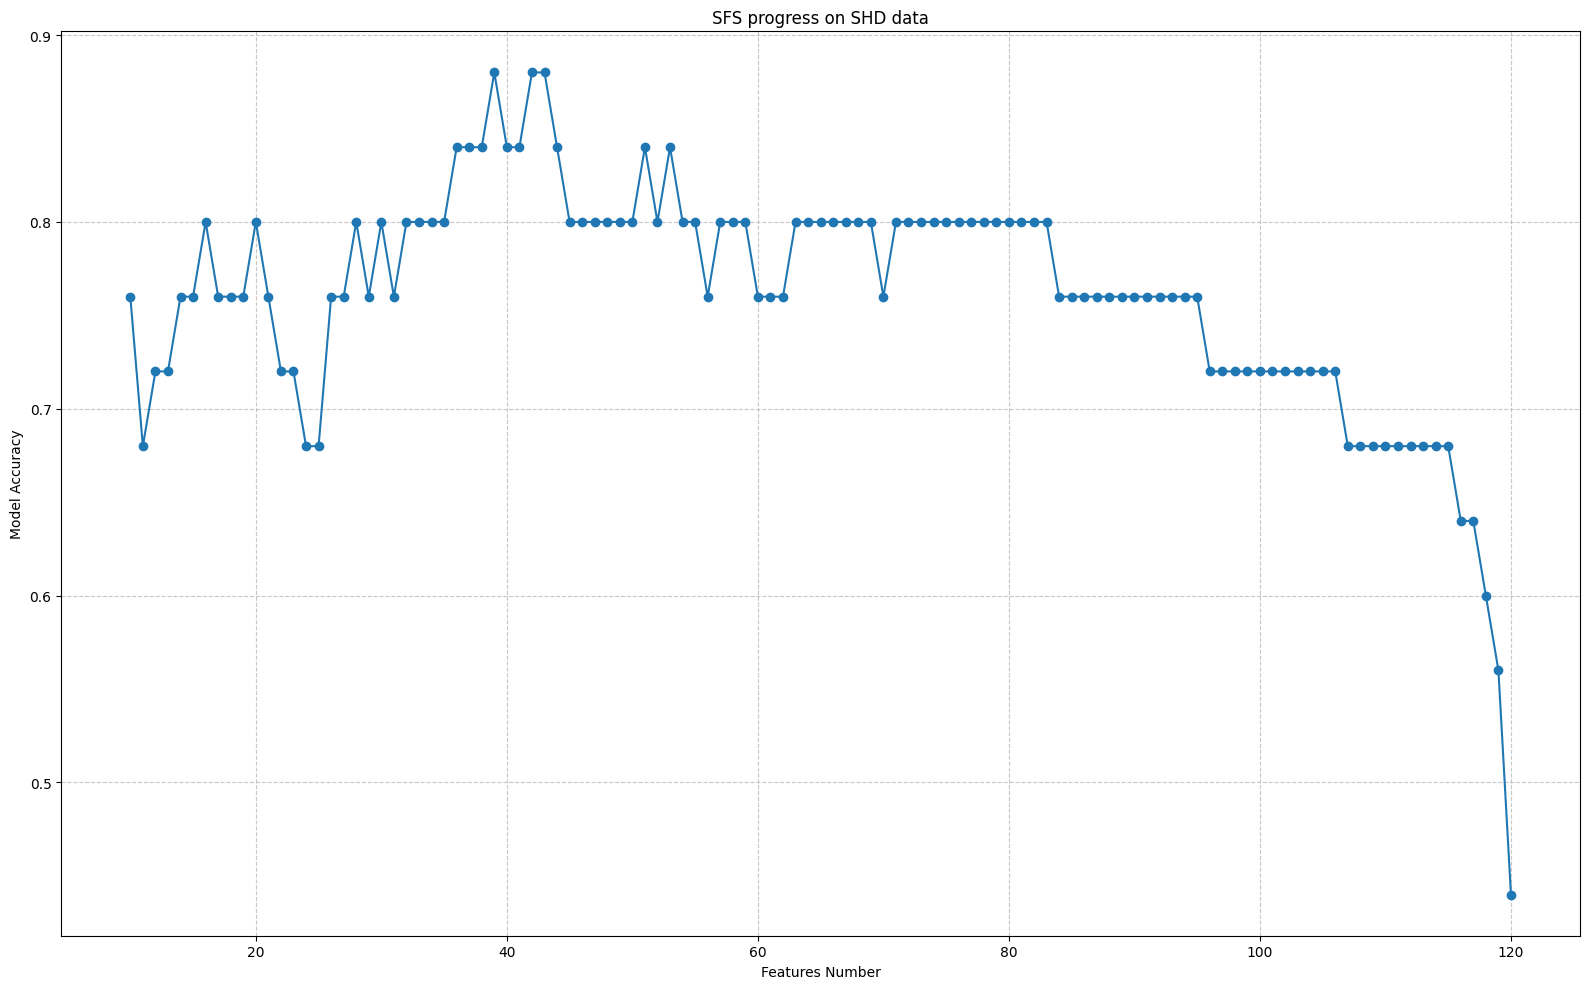

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def use_custom_SFS(dataset_name, data, n_features, forward=True):
  X, y, features = data
  knn = KNeighborsClassifier(n_neighbors=5)
  sfs = SequentialFeatureSelection(
      knn, k_features=n_features, forward=forward
  )
  sfs.fit(X, y)
  best_features = features[np.array(sfs.indices_)]
  output_result(dataset_name, n_features, best_features)
  plot_feature_selection_performance(
      [len(k) for k in sfs.subsets_], sfs.scores_,
      title=f"SFS progress on {dataset_name.upper()} data"
  )

print("[Forward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_custom_SFS(dataset, datasets[dataset], n_features)
print()

print("[Backward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_custom_SFS(dataset, datasets[dataset], n_features, forward=False)

Застосуємо алгоритм sklearn.feature_selection.SequentialFeatureSelector. Розглянемо варіанти forward та backward цього алгоритму. Для крос-валідації використовуватимемо 3 фолди, а для оцінки важливості ознак застосуємо KNeighborsClassifier.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

def use_SFS(dataset_name, data, n_features, direction):
  X, y, features = data
  knn = KNeighborsClassifier(n_neighbors=5)
  sfs = SequentialFeatureSelector(
      knn, n_features_to_select=n_features, direction=direction, cv=3
  )
  sfs.fit(X, y)
  best_features = sfs.get_feature_names_out(input_features=features)
  output_result(dataset_name, n_features, best_features)

print("[Forward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_SFS(dataset, datasets[dataset], n_features, "forward")

print("[Backward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_SFS(dataset, datasets[dataset], n_features, "backward")

[Forward SFS]
Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  texture_mean, concavity_mean, concave_points_mean, symmetry_mean, smoothness_se, concavity_se, texture_worst, perimeter_worst, area_worst

Best 5 features from synthetc data (n_features < n_samples):
  F0, F12, F13, F16, F18

Best 10 features from synthetc data (n_features > n_samples):
  F2, F27, F30, F35, F47, F51, F83, F107, F113, F116

[Backward SFS]
Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  radius_mean, symmetry_mean, fractal_dimension_mean, radius_se, smoothness_se, texture_worst, perimeter_worst, smoothness_worst, concavity_worst

Best 5 features from synthetc data (n_features < n_samples):
  F5, F8, F9, F13, F18

Best 10 features from synthetc data (n_features > n_samples):
  F9, F33, F50, F68, F79, F97, F100, F106, F117, F118



Застосуємо алгоритм SelectFromModel. Дослідимо цей алгоритм для логістичної регресії, яка підтримує L1-регуляризацію. Виберемо ознаки на основі моделі з порогом важливості 0.8.

In [ ]:
from sklearn.feature_selection import SelectFromModel

def use_SFM_with_L1(dataset_name, data):
  X, y, features = data
  lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
  lr.fit(X, y)
  sfm = SelectFromModel(lr, threshold=0.8, prefit=True)
  X_selected = sfm.transform(X)
  n_features = X_selected.shape[1]
  best_features = features[sfm.get_support(indices=True)]
  output_result(dataset_name, n_features, best_features, X_selected)

for dataset in datasets:
  use_SFM_with_L1(dataset, datasets[dataset])

Best 8 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  concave_points_mean, radius_se, compactness_se, radius_worst, texture_worst, area_worst, concavity_worst, concave_points_worst
Selected data:
[[ 2.53247522  2.48973393  1.31686157 ...  2.00123749  2.10952635
   2.29607613]
 [ 0.54814416  0.4992546  -0.69292627 ...  1.89048899 -0.14674897
   1.0870843 ]
 [ 2.03723076  1.22867595  0.8149735  ...  1.45628455  0.85497394
   1.95500035]
 ...
 [ 0.10577736  0.18489241  0.66127727 ...  0.42790561  0.3267666
   0.41406869]
 [ 2.65886573  1.15793543  2.01771639 ...  1.65317077  3.19760468
   2.28998549]
 [-1.26181958 -0.07027874 -1.16351619 ... -1.07581292 -1.30583065
  -1.74506282]]

Best 6 features from synthetc data (n_features < n_samples):
  F5, F8, F9, F13, F16, F18
Selected data:
[[-1.4100144   0.06710414  0.55104245 -0.31300757 -0.0057786   2.11413797]
 [-1.36544545  0.15207247 -1.02194402  0.73143346  0.55911151  1.18152997]
 [-1.15037356 -0.0776965  -1.55922071  1.43

Дослідимо алгоритм SelectFromModel для моделі класифікації випадкових лісів. Використаємо 500 дерев. Відбиратимемо ознаки з різним порогом важливості залежно від датасету.

Best 5 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  concave_points_mean, radius_worst, perimeter_worst, area_worst, concave_points_worst
Selected data:
[[ 2.53247522  1.88668963  2.30360062  2.00123749  2.29607613]
 [ 0.54814416  1.80592744  1.53512599  1.89048899  1.0870843 ]
 [ 2.03723076  1.51187025  1.34747521  1.45628455  1.95500035]
 ...
 [ 0.10577736  0.56136143  0.57900058  0.42790561  0.41406869]
 [ 2.65886573  1.96123934  2.30360062  1.65317077  2.28998549]
 [-1.26181958 -1.41089258 -1.43273495 -1.07581292 -1.74506282]]



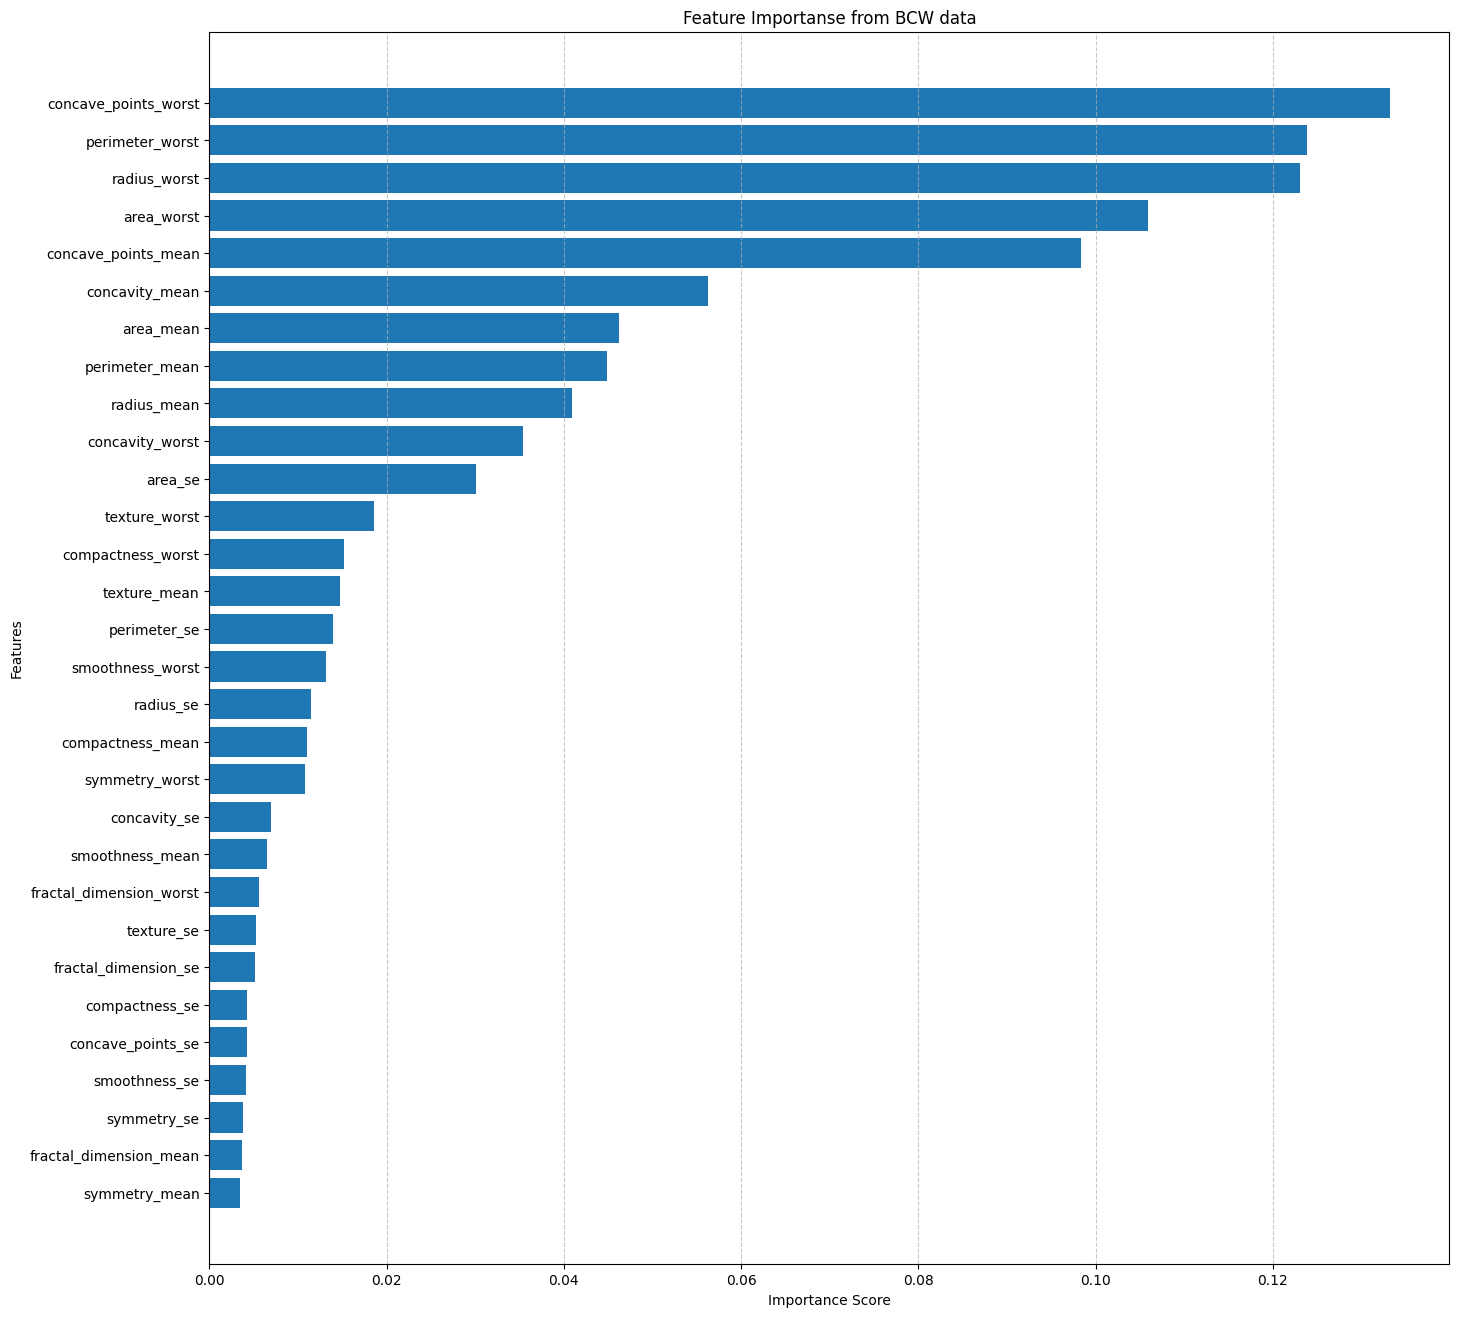

Best 6 features from synthetc data (n_features < n_samples):
  F0, F5, F8, F13, F16, F18
Selected data:
[[ 0.26755103 -1.4100144   0.06710414 -0.31300757 -0.0057786   2.11413797]
 [-0.34823128 -1.36544545  0.15207247  0.73143346  0.55911151  1.18152997]
 [-0.18008084 -1.15037356 -0.0776965   1.43489165  0.42472437  0.88245828]
 ...
 [ 0.37910337 -1.07693381 -0.24643403  0.57612546 -0.13217757  1.85226727]
 [-0.369858   -1.51179716 -0.83428653  2.69643574  1.17289317  0.52447244]
 [-1.12801174 -1.65883339 -1.12572397 -0.37393384  1.53103745  4.43970819]]



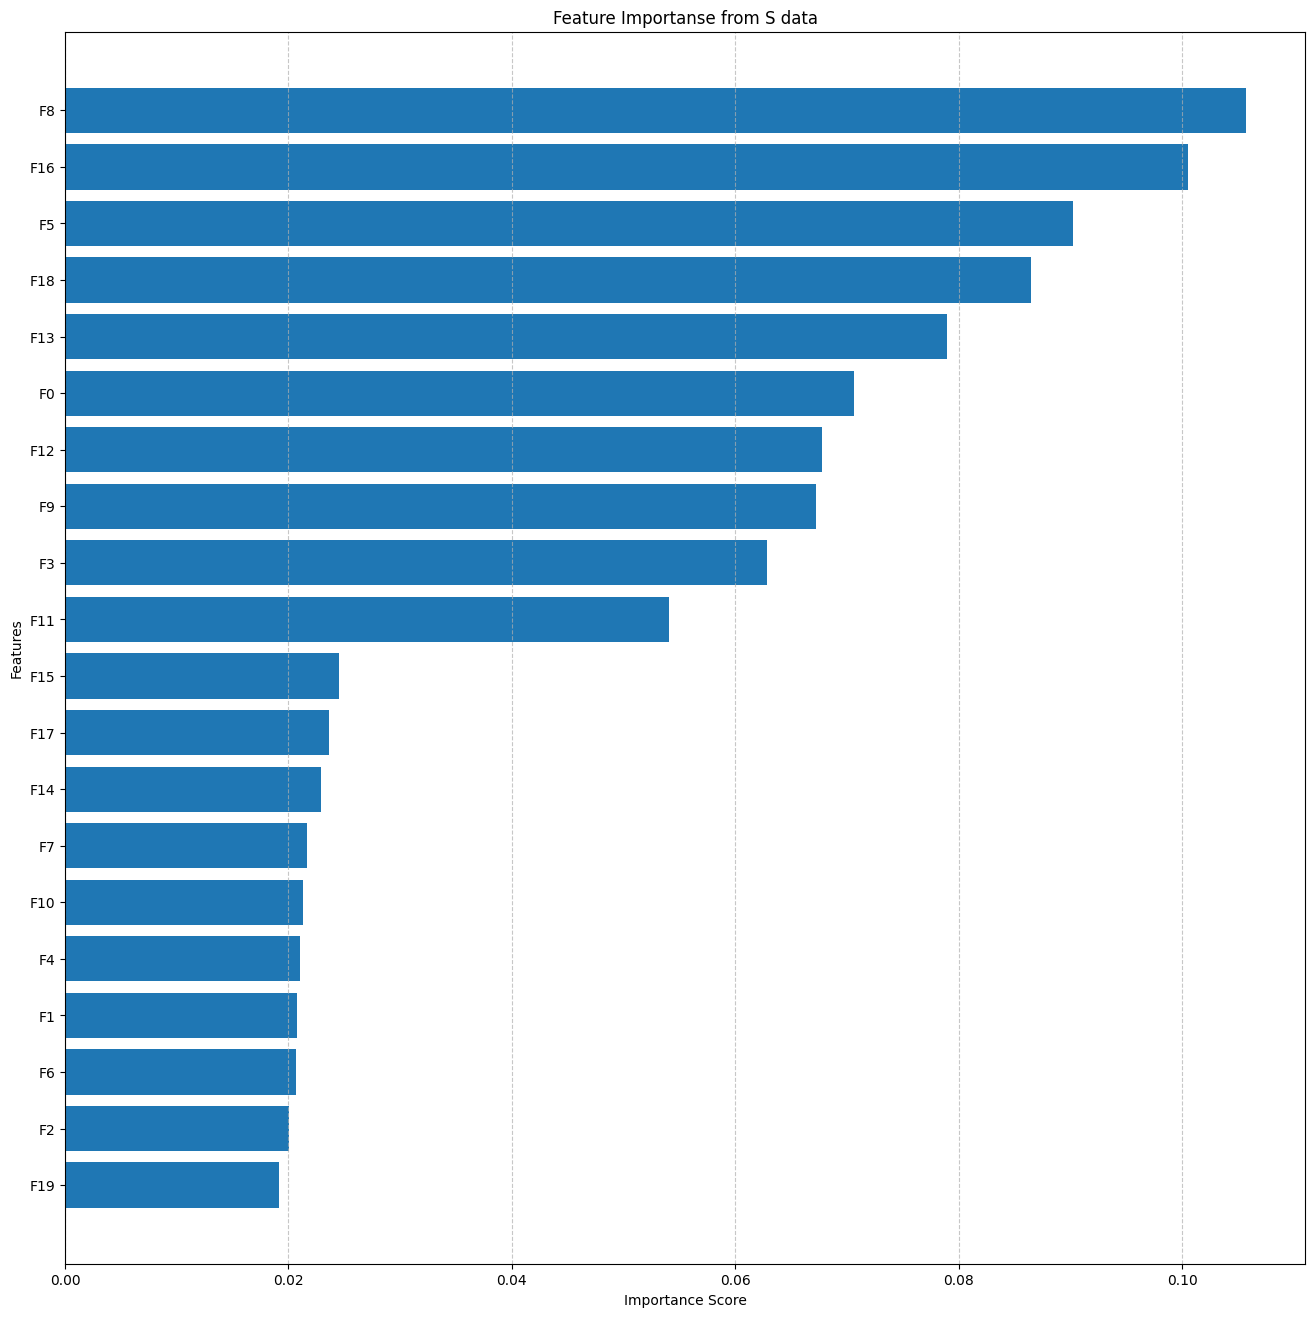

Best 12 features from synthetc data (n_features > n_samples):
  F1, F9, F18, F33, F50, F68, F74, F79, F97, F100, F106, F114
Selected data:
[[-1.88380246 -1.29986252 -0.78137415 ...  1.94378108  1.85466404
  -0.73133217]
 [ 0.59220736 -1.84135619 -1.09291881 ... -0.33837316  1.26375659
   0.4630657 ]
 [ 0.79785343  0.66417822  1.13362918 ...  0.86141461 -1.92785425
  -0.87939875]
 ...
 [ 1.07440627  3.14448655  0.65680967 ... -1.50868705 -2.67085331
  -0.09099246]
 [-1.40380789  3.5961233   0.49928539 ... -1.05503388 -0.72015441
   1.60754381]
 [-0.8425412   2.02838352  0.10472464 ... -0.64267643  1.01586472
   0.22343001]]



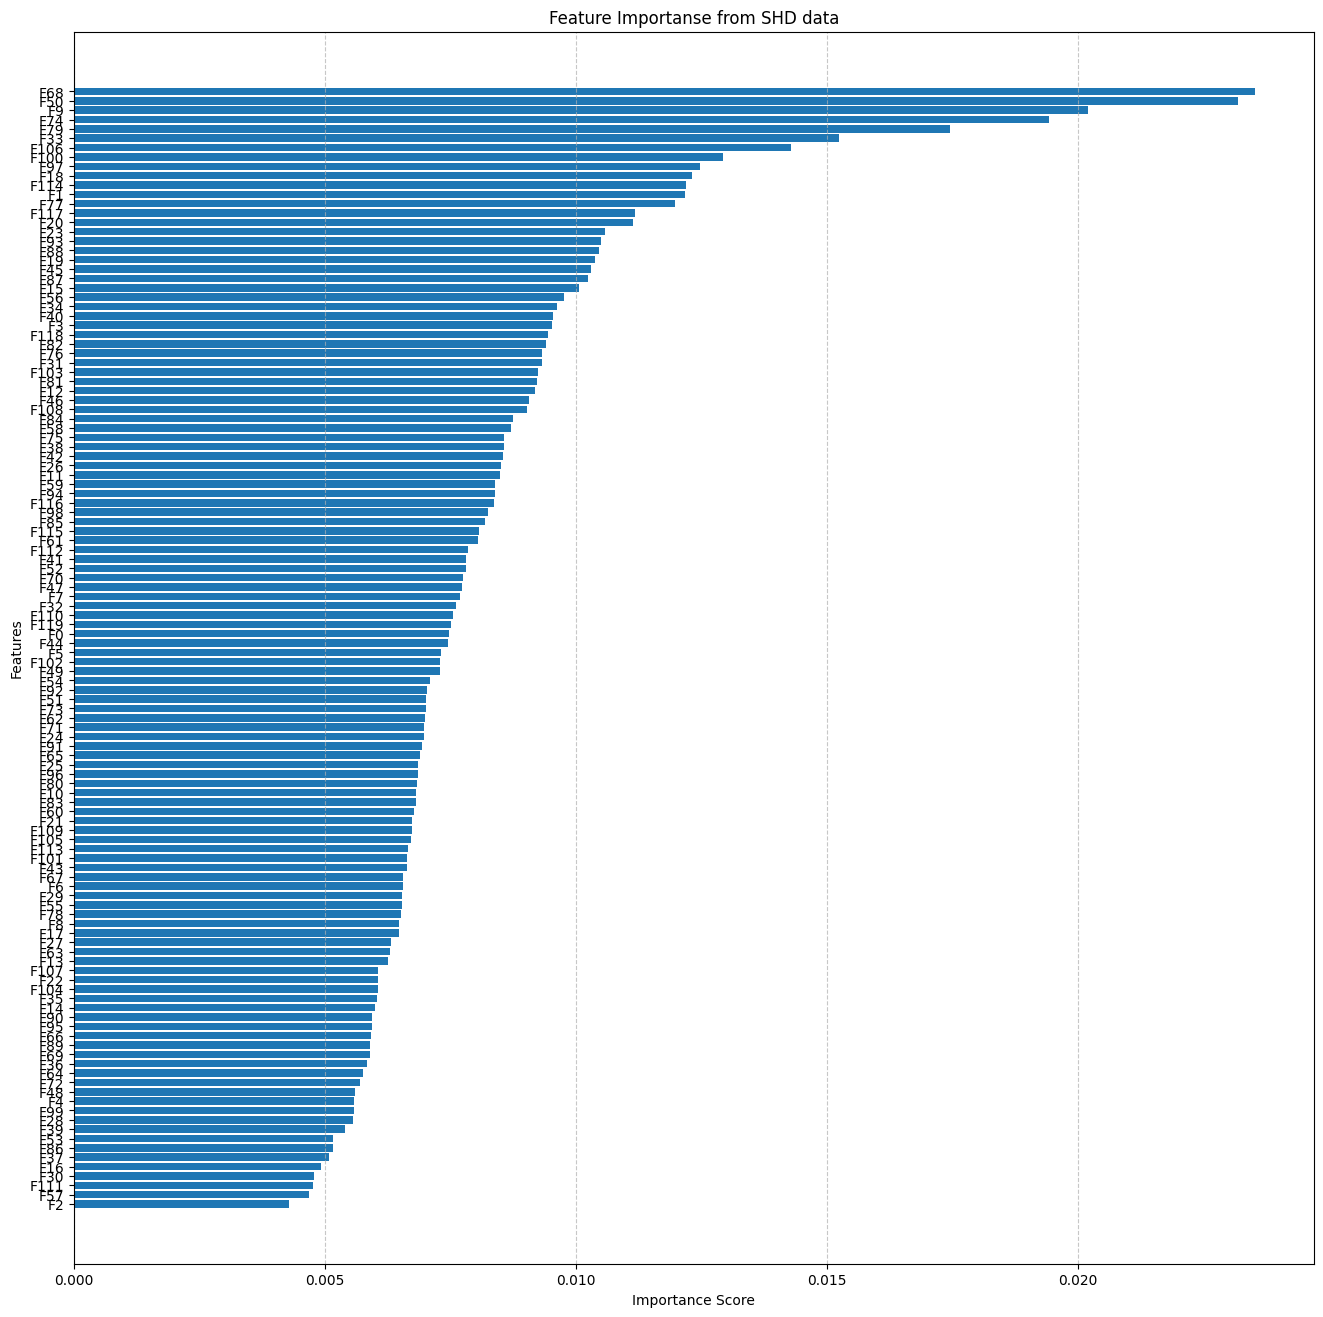

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def use_SFM_with_RFC(dataset_name, data, threshold):
  X, y, features = data
  forest = RandomForestClassifier(n_estimators=500, random_state=1)
  forest.fit(X, y)
  sfm = SelectFromModel(forest, threshold=threshold, prefit=True)
  X_selected = sfm.transform(X)
  n_features = X_selected.shape[1]
  importances = forest.feature_importances_
  best_features = features[sfm.get_support(indices=True)]
  output_result(dataset_name, n_features, best_features, X_selected)
  plot_feature_importance(
      features, importances,
      title=f"Feature Importanse from {dataset_name.upper()} data"
  )

for dataset, threshold in zip(datasets, [0.09, 0.07, 0.012]):
  use_SFM_with_RFC(dataset, datasets[dataset], threshold)

###Оцінювання важливості ознак з використанням алгоритмів, реалізованих в mlxtend python

Застосуємо алгоритм SequentialFeatureSelector (варіанти forward та backward). Застосуємо алгоритм ColumnSelector для вибору ознак, отриманих алгоритмом SequentialFeatureSelector. Як модель класифікації застосуємо метод К-найближчих сусідів KNeighborsClassifier. Метрикою оберемо точність та  використаємо 3 фолди крос-валідації.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ColumnSelector

def use_ml_SFS_with_CS(dataset_name, data, n_features, forward=True):
  X, y, features = data
  knn = KNeighborsClassifier(n_neighbors=4)
  sfs = SequentialFeatureSelector(
      knn, k_features=n_features, forward=forward, floating=False,
      scoring='accuracy', cv=3
  )
  sfs.fit(X, y)
  best_features = features[np.array(sfs.k_feature_idx_)]
  col_selector = ColumnSelector(cols=sfs.k_feature_idx_)
  X_selected = col_selector.fit_transform(X)
  output_result(dataset_name, n_features, best_features, X_selected)

print("[Forward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_ml_SFS_with_CS(dataset, datasets[dataset], n_features)
print()

print("[Backward SFS]")
for dataset, n_features in zip(datasets, [9, 5, 10]):
  use_ml_SFS_with_CS(dataset, datasets[dataset], n_features, False)

[Forward SFS]
Best 9 features from Breast Cancer Wisconsin (Diagnostic) Dataset:
  radius_mean, texture_mean, area_mean, concave_points_mean, radius_worst, perimeter_worst, smoothness_worst, concavity_worst, symmetry_worst
Selected data:
[[ 1.09706398 -2.07333501  0.9843749  ...  1.30768627  2.10952635
   2.75062224]
 [ 1.82982061 -0.35363241  1.90870825 ... -0.37561196 -0.14674897
  -0.24388967]
 [ 1.57988811  0.45618695  1.55888363 ...  0.52740741  0.85497394
   1.152255  ]
 ...
 [ 0.70228425  2.0455738   0.57795264 ... -0.80958728  0.3267666
  -1.10454895]
 [ 1.83834103  2.33645719  1.73521799 ...  1.43042677  3.19760468
   1.91908301]
 [-1.80840125  1.22179204 -1.34778924 ... -1.85901852 -1.30583065
  -0.04813821]]

Best 5 features from synthetc data (n_features < n_samples):
  F3, F5, F8, F9, F13
Selected data:
[[ 1.26662853 -1.4100144   0.06710414  0.55104245 -0.31300757]
 [-0.13323621 -1.36544545  0.15207247 -1.02194402  0.73143346]
 [-0.54377844 -1.15037356 -0.0776965  -1.55922

###Порівняння результатів за різними алгоритмами

У ході дослідження було отримано результати оцінки важливості ознак для трьох різних наборів даних з використанням кількох алгоритмів відбору ознак.

Для датасету Breast Cancer Wisconsin (BCW), де кількість записів суттєво перевищує кількість ознак, більшість методів стабільно визначали ключові ознаки concavity_mean, concave_points_mean та radius_worst. Univariate Feature Selection та SelectFromModel (RandomForestClassifier) виділили схожі ознаки, що підтвердило їхню ефективність. RFECV з крос-валідацією показав хорошу стабільність при використанні 24 ознак, тоді як обидва варіанти алгоритмів Sequential Feature Selection досягли максимальної точності при 9-18 ознаках.

У випадку штучно згенерованого датасету, де кількість ознак була меншою за кількість записів (n_features < n_samples), майже всі методи стабільно виділяли F5, F8, F9, F13, F16, F18 як найбільш інформативні. Найкращі результати показали RFECV з крос-валідацією та SelectFromModel (L1, RandomForestClassifier), які змогли коректно визначити більшість інформативних ознак. Sequential Feature Selection (особливо backward) також виявився ефективним, досягаючи високої точності при виборі 6 ознак.

Найскладнішою для аналізу виявилася ситуація, коли кількість ознак перевищувала кількість записів (n_features > n_samples). У цьому випадку результати відрізнялися залежно від методу. Univariate Feature Selection та стандартний RFE часто включали випадкові ознаки. RFECV обрав 45 ознак, але якість моделі при цьому була нестабільною - відхилення було дуже великим. Найкращі результати дали SelectFromModel (L1, RandomForestClassifier) та backward-варіант Sequential Feature Selection, які знаходили найбільш значущі ознаки, хоча їхня точність залишалася нижчою порівняно з іншими наборами даних.

Найстабільніші результати показали Recursive Feature Elimination з крос-валідацією (RFECV) та SelectFromModel (L1-регуляризація, RandomForestClassifier), які ефективно виділяли найбільш інформативні ознаки в усіх випадках. Sequential Feature Selection (особливо backward) також продемонстрував високу точність, особливо для датасетів із меншою кількістю ознак. Для випадку, коли n_features > n_samples, найкращими методами виявилися SelectFromModel та backward-варіант покрокового відбору, хоча їхні результати були менш стабільними.

###Порівняння результатів з умовами моделювання для штучно згенерованих даних

Під час аналізу важливості ознак для штучно згенерованих даних можна помітити, що різні методи по-різному справляються з визначенням інформативних ознак залежно від розмірності набору даних та співвідношення кількості ознак та записів у ньому.

Якщо кількість ознак менша за кількість записів (20 ознак, 600 записів), більшість методів досить точно визначають найбільш значущі ознаки. Наприклад, Univariate feature selection та RFE виділили F0, F5, F8, F9, F13, F16, F18, що частково збігається з інформативними (F0-F4) ознаками. Найбільш точними виявилися методи RFE з крос-валідацією, Custom SFS та SelectFromModel (L1, RandomForest), які найкраще визначили правильний набір ознак.

Коли ж кількість ознак значно перевищувала кількість записів (120 ознак, 100 записів), результати виявилися менш точними. Багато методів визначили більше ознак, ніж є насправді інформативними. Наприклад, Univariate feature selection та RFE виділили 10–12 ключових ознак, серед яких F9, F19, F33, F50, F68, F74, F79, F100, F106, F108. Деякі з них збігаються з очікуваними (F0-F9), але більшість з них не є очікуваними. RFE з крос-валідацією відбирає ще більше ознак (близько 45), що свідчить про складність вибору. Аналогічну нестабільність показали backward-варіанти методів Custom SFS, sklearn SFS, тоді як SelectFromModel (L1, RandomForest) давав стабільніші результати (12-22 ознаки, частково правильні).

В цілому результати підтверджують, що методи відбору ознак працюють краще, коли кількість записів значно перевищує кількість ознак. Якщо ж ознак дуже багато, методи стають менш точними, а результати відрізняються залежно від алгоритму.

##Висновок

У цій лабораторній роботі було досліджено різні методи оцінки важливості ознак. Також було порівняно ефективність цих методів на трьох наборах даних.

Найкращі результати показали Recursive Feature Elimination з крос-валідацією та SelectFromModel, особливо для випадків, де кількість записів перевищувала кількість ознак. Sequential Feature Selection (backward) виявився ефективним для обох типів штучно згенерованих даних (n_features > n_samples та n_features < n_samples), але у випадку більшої кількості ознак точність була нестабільною. Для набору даних з більшою кількістю ознак, ніж записів, результати були нестабільними та мали велике відхилення, що підтверджує складність вибору в такому випадку.

##Джерело даних
UCI Machine Learning Repository: Breast Cancer Wisconsin (Diagnostic) Data Set.
Доступно за посиланням: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic).